<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/VoxNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Libraries

In [1]:
#common libraries
import numpy as np
import os
import math
import random
from collections import OrderedDict

#torch package
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip install torchmetrics
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss

#to manage OFF files and transform to voxel grid
!pip install open3d;
import open3d as o3d

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

#to manage with progression and time in train and evaluate phase 
import time
from tqdm import tqdm

!pip install Pillow==9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 21.8 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
open3d 0.17.0 requires pillow>=9.3.0, but you have pillow 9.0.0 which is incompatible.


# Download and unzip the dataset ModelNet10

In [2]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2023-06-02 16:30:56--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-06-02 16:30:56--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  86.7MB/s    in 5.3s    

2023-06-02 16:31:01 (85.8 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [3]:
!unzip -q ModelNet10.zip;

# Voxelization of the off. files in dataset

In [ ]:
ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}
Z = {'train': [], 'test': []}

rot = 0

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            if (rot%8)==0:
              mesh = mesh
              rotat = 0
              rot +=1
            elif (rot%8)==1:
              mesh.rotate(r45)
              rotat = 1
              rot +=1
            elif (rot%8)==2:
              mesh.rotate(r90)
              rotat = 2
              rot +=1
            elif (rot%8)==3:
              mesh.rotate(r135) 
              rotat = 3 
              rot +=1
            elif (rot%8)==4:
              mesh.rotate(r180)
              rotat = 4
              rot +=1
            elif (rot%8)==5:
              mesh.rotate(r225)
              rotat = 5
              rot +=1
            elif (rot%8)==6:
              mesh.rotate(r270)
              rotat = 6
              rot+=1
            else:
              mesh.rotate(r315)
              rotat = 7
              rot+=1
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)
            Z[split].append(rotat)

100%|██████████| 101/101 [00:06<00:00, 16.55it/s]


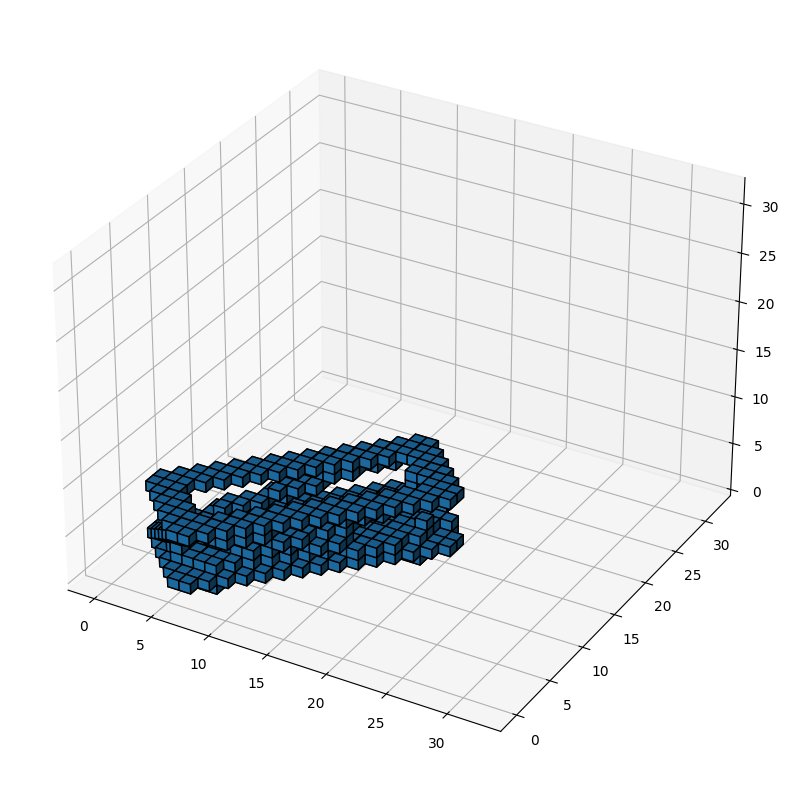

In [ ]:
mesh = o3d.io.read_triangle_mesh('/content/ModelNet10/bathtub/train/bathtub_0003.off')
mesh.rotate(r315)
              
mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)

vox_grid = voxel_grid.get_voxels()
vox_g = np.zeros((32, 32, 32), dtype=np.int32)
for i in range (len(vox_grid)):
  voxel_index = vox_grid[i].grid_index
  vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1


ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.voxels(vox_g, edgecolor='k')
plt.show()

# Dataset setup and Trainer

In [ ]:
class VoxelDataset(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label1 = Y['train']
          self.label2 = Z['train']
      else:
          self.data = X['test']
          self.label1 = Y['test']
          self.label2 = Z['test']
        
                
    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [ ]:
class VoxNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      self.alpha = 2/3
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = VoxelDataset(train=True)
      self.test_ds = VoxelDataset(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet":
          self.model = VoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet was chosen")
      elif self.name_model == "BatchNormVoxNet":
          self.model = BatchNormVoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model BatchNormVoxNet was chosen")
      else:
        self.model = DMPVoxNet()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPVoxNet was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.loss_fn = nn.CrossEntropyLoss()
      #self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)
      #self.lr_scheduler = torch.optim.lr_scheduler.LinearLR(self.opt, start_factor=1, end_factor=0.05, total_iters=50)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
   

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []

          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu()) 
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu()) 
            
              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
              #pred_choice = pred.data.max(1)[1]
              #correct = pred_choice.eq(labels.data).cpu().sum()
          self.lr_scheduler.step()
                      
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []       
            pred_test2 = []  
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()  

                '''
                pred_test1.append(self.model(inputs_test)[0])
                pred_test2.append(self.model(inputs_test)[1])
                pred_test = []
                labels_test = []
                for k in range(0, 25, 8):
                    temp = pred_test1[j]
                    tempo = temp[k:k+7,:]
                    pred_test.append(np.einsum('ij->j', tempo))
                    temp2 = labels_test1
                    labels_test.append(temp2[k])

                pred_test_t = torch.tensor(pred_test)
                labels_test_t = torch.tensor(labels_test)
                pred_test2_t = torch.tensor(pred_test2[j])
                loss_test = self.loss_fn(pred_test_t, labels_test_t) 
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test_t, 1).cpu(), labels_test_t.cpu())
                valid_accuracy2.update(torch.argmax(pred_test2_t, 1).cpu(), labels_test2.cpu())
                pred_choice_test = pred_test_t.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test_t.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test_t, 1))
                self.y_conf.append(labels_test_t)
                '''
                
                pred_test1, pred_test2 = self.model(inputs_test)  # torch.Size([256, 10])
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu()) 
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu()) 
                
                #correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)
      

          # total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)
          
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model 
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
  
      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

# VoxNet

In [4]:
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3, stride=1)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu2', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x1, x2
        return self.logsoftmax(x1), self.logsoftmax(x2)

**VoxNet** training

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.6,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet'
}    

trainer1 = VoxNet_Trainer(training_hyperparameters)
trainer1.train()

model VoxNet was chosen
62.359375


Train loss: 1.21038019657135: : 62it [00:18,  3.40it/s]
29it [00:01, 15.96it/s]


epoch:  1 / 50
time: 20.06 seconds
train-loss: 1.43, train-acc-object: 49.80%, train-acc-pose: 40.15%
valid-loss: 1.05, valid-acc-object: 63.22%, train-acc-pose: 56.39%



Train loss: 0.7617425918579102: : 62it [00:10,  6.07it/s]
29it [00:01, 15.73it/s]


epoch:  2 / 50
time: 12.08 seconds
train-loss: 0.85, train-acc-object: 72.23%, train-acc-pose: 60.36%
valid-loss: 0.76, valid-acc-object: 73.68%, train-acc-pose: 61.34%



Train loss: 0.7799978256225586: : 62it [00:10,  5.99it/s]
29it [00:01, 15.11it/s]


epoch:  3 / 50
time: 12.28 seconds
train-loss: 0.67, train-acc-object: 79.18%, train-acc-pose: 69.63%
valid-loss: 0.68, valid-acc-object: 76.65%, train-acc-pose: 66.52%



Train loss: 0.4357844293117523: : 62it [00:10,  6.04it/s]
29it [00:01, 15.93it/s]


epoch:  4 / 50
time: 12.11 seconds
train-loss: 0.57, train-acc-object: 82.56%, train-acc-pose: 73.54%
valid-loss: 0.70, valid-acc-object: 74.67%, train-acc-pose: 68.61%



Train loss: 0.5441179871559143: : 62it [00:10,  6.01it/s]
29it [00:01, 15.64it/s]


epoch:  5 / 50
time: 12.19 seconds
train-loss: 0.50, train-acc-object: 83.29%, train-acc-pose: 75.15%
valid-loss: 0.64, valid-acc-object: 77.64%, train-acc-pose: 69.60%



Train loss: 0.33302727341651917: : 62it [00:10,  6.12it/s]
29it [00:02, 13.89it/s]


epoch:  6 / 50
time: 12.23 seconds
train-loss: 0.42, train-acc-object: 86.72%, train-acc-pose: 80.19%
valid-loss: 0.57, valid-acc-object: 80.84%, train-acc-pose: 70.93%



Train loss: 0.34505951404571533: : 62it [00:09,  6.55it/s]
29it [00:02, 10.22it/s]


epoch:  7 / 50
time: 12.32 seconds
train-loss: 0.38, train-acc-object: 88.71%, train-acc-pose: 79.79%
valid-loss: 0.57, valid-acc-object: 80.29%, train-acc-pose: 71.15%



Train loss: 0.36742615699768066: : 62it [00:09,  6.82it/s]
29it [00:02, 10.33it/s]


epoch:  8 / 50
time: 11.92 seconds
train-loss: 0.35, train-acc-object: 89.36%, train-acc-pose: 81.55%
valid-loss: 0.56, valid-acc-object: 81.83%, train-acc-pose: 72.58%



Train loss: 0.2975390553474426: : 62it [00:09,  6.53it/s]
29it [00:02, 13.86it/s]


epoch:  9 / 50
time: 11.60 seconds
train-loss: 0.33, train-acc-object: 90.47%, train-acc-pose: 82.71%
valid-loss: 0.59, valid-acc-object: 80.40%, train-acc-pose: 72.69%



Train loss: 0.31679847836494446: : 62it [00:10,  6.10it/s]
29it [00:01, 15.77it/s]


epoch: 10 / 50
time: 12.02 seconds
train-loss: 0.30, train-acc-object: 90.47%, train-acc-pose: 83.54%
valid-loss: 0.58, valid-acc-object: 81.72%, train-acc-pose: 72.69%



Train loss: 0.24398288130760193: : 62it [00:10,  6.05it/s]
29it [00:01, 15.61it/s]


epoch: 11 / 50
time: 12.13 seconds
train-loss: 0.27, train-acc-object: 91.86%, train-acc-pose: 84.53%
valid-loss: 0.57, valid-acc-object: 81.94%, train-acc-pose: 75.55%



Train loss: 0.33347946405410767: : 62it [00:10,  5.87it/s]
29it [00:01, 15.43it/s]


epoch: 12 / 50
time: 12.46 seconds
train-loss: 0.25, train-acc-object: 92.92%, train-acc-pose: 85.11%
valid-loss: 0.58, valid-acc-object: 81.39%, train-acc-pose: 74.45%



Train loss: 0.18970239162445068: : 62it [00:10,  5.98it/s]
29it [00:01, 14.87it/s]


epoch: 13 / 50
time: 12.34 seconds
train-loss: 0.24, train-acc-object: 93.70%, train-acc-pose: 87.00%
valid-loss: 0.60, valid-acc-object: 82.05%, train-acc-pose: 74.34%



Train loss: 0.16748583316802979: : 62it [00:10,  5.72it/s]
29it [00:01, 14.68it/s]


epoch: 14 / 50
time: 12.83 seconds
train-loss: 0.23, train-acc-object: 94.00%, train-acc-pose: 86.52%
valid-loss: 0.58, valid-acc-object: 82.38%, train-acc-pose: 75.22%



Train loss: 0.33554866909980774: : 62it [00:10,  5.80it/s]
29it [00:01, 15.10it/s]


epoch: 15 / 50
time: 12.63 seconds
train-loss: 0.23, train-acc-object: 93.98%, train-acc-pose: 86.14%
valid-loss: 0.59, valid-acc-object: 81.61%, train-acc-pose: 74.67%



Train loss: 0.24978125095367432: : 62it [00:10,  5.74it/s]
29it [00:01, 14.96it/s]


epoch: 16 / 50
time: 12.75 seconds
train-loss: 0.20, train-acc-object: 94.66%, train-acc-pose: 87.88%
valid-loss: 0.58, valid-acc-object: 82.27%, train-acc-pose: 75.66%



Train loss: 0.21472294628620148: : 62it [00:10,  5.93it/s]
29it [00:01, 15.58it/s]


epoch: 17 / 50
time: 12.34 seconds
train-loss: 0.19, train-acc-object: 95.09%, train-acc-pose: 89.11%
valid-loss: 0.58, valid-acc-object: 82.82%, train-acc-pose: 75.88%



Train loss: 0.15727302432060242: : 62it [00:10,  5.94it/s]
29it [00:01, 14.76it/s]


epoch: 18 / 50
time: 12.42 seconds
train-loss: 0.18, train-acc-object: 95.44%, train-acc-pose: 88.84%
valid-loss: 0.58, valid-acc-object: 82.16%, train-acc-pose: 75.88%



Train loss: 0.16750100255012512: : 62it [00:09,  6.28it/s]
29it [00:02, 11.53it/s]


epoch: 19 / 50
time: 12.41 seconds
train-loss: 0.18, train-acc-object: 95.31%, train-acc-pose: 88.71%
valid-loss: 0.60, valid-acc-object: 81.83%, train-acc-pose: 74.89%



Train loss: 0.12850122153759003: : 62it [00:09,  6.61it/s]
29it [00:03,  9.31it/s]


epoch: 20 / 50
time: 12.52 seconds
train-loss: 0.17, train-acc-object: 95.72%, train-acc-pose: 89.82%
valid-loss: 0.60, valid-acc-object: 82.38%, train-acc-pose: 75.33%



Train loss: 0.1354755461215973: : 62it [00:09,  6.65it/s]
29it [00:02, 10.56it/s]


epoch: 21 / 50
time: 12.08 seconds
train-loss: 0.17, train-acc-object: 95.92%, train-acc-pose: 90.20%
valid-loss: 0.58, valid-acc-object: 82.60%, train-acc-pose: 75.55%



Train loss: 0.27218693494796753: : 62it [00:09,  6.35it/s]
29it [00:02, 13.33it/s]


epoch: 22 / 50
time: 11.96 seconds
train-loss: 0.16, train-acc-object: 95.99%, train-acc-pose: 90.35%
valid-loss: 0.59, valid-acc-object: 82.27%, train-acc-pose: 75.88%



Train loss: 0.2642231583595276: : 62it [00:10,  5.97it/s]
29it [00:01, 15.24it/s]


epoch: 23 / 50
time: 12.30 seconds
train-loss: 0.16, train-acc-object: 96.09%, train-acc-pose: 89.84%
valid-loss: 0.59, valid-acc-object: 82.49%, train-acc-pose: 75.00%



Train loss: 0.11692196130752563: : 62it [00:10,  5.85it/s]
29it [00:01, 15.58it/s]


epoch: 24 / 50
time: 12.48 seconds
train-loss: 0.16, train-acc-object: 95.79%, train-acc-pose: 90.35%
valid-loss: 0.60, valid-acc-object: 82.71%, train-acc-pose: 75.44%



Train loss: 0.14407549798488617: : 62it [00:10,  5.90it/s]
29it [00:01, 15.44it/s]


epoch: 25 / 50
time: 12.40 seconds
train-loss: 0.15, train-acc-object: 96.17%, train-acc-pose: 90.78%
valid-loss: 0.60, valid-acc-object: 82.16%, train-acc-pose: 75.77%



Train loss: 0.15169933438301086: : 62it [00:10,  5.90it/s]
29it [00:01, 15.20it/s]


epoch: 26 / 50
time: 12.44 seconds
train-loss: 0.15, train-acc-object: 96.52%, train-acc-pose: 90.35%
valid-loss: 0.60, valid-acc-object: 82.49%, train-acc-pose: 75.88%



Train loss: 0.1272089183330536: : 62it [00:10,  5.91it/s]
29it [00:01, 15.41it/s]


epoch: 27 / 50
time: 12.40 seconds
train-loss: 0.15, train-acc-object: 96.62%, train-acc-pose: 90.12%
valid-loss: 0.60, valid-acc-object: 83.15%, train-acc-pose: 76.65%



Train loss: 0.13961553573608398: : 62it [00:10,  5.86it/s]
29it [00:01, 14.97it/s]


epoch: 28 / 50
time: 12.54 seconds
train-loss: 0.15, train-acc-object: 96.60%, train-acc-pose: 90.55%
valid-loss: 0.59, valid-acc-object: 82.93%, train-acc-pose: 76.21%



Train loss: 0.1672687530517578: : 62it [00:10,  5.77it/s]
29it [00:01, 15.30it/s]


epoch: 29 / 50
time: 12.66 seconds
train-loss: 0.15, train-acc-object: 96.47%, train-acc-pose: 90.52%
valid-loss: 0.60, valid-acc-object: 82.49%, train-acc-pose: 75.77%



Train loss: 0.12351536750793457: : 62it [00:10,  5.89it/s]
29it [00:01, 14.86it/s]


epoch: 30 / 50
time: 12.50 seconds
train-loss: 0.14, train-acc-object: 96.77%, train-acc-pose: 91.48%
valid-loss: 0.59, valid-acc-object: 82.93%, train-acc-pose: 76.65%



Train loss: 0.15041764080524445: : 62it [00:10,  5.89it/s]
29it [00:01, 15.35it/s]


epoch: 31 / 50
time: 12.43 seconds
train-loss: 0.14, train-acc-object: 96.93%, train-acc-pose: 91.33%
valid-loss: 0.59, valid-acc-object: 83.26%, train-acc-pose: 75.99%



Train loss: 0.09499771893024445: : 62it [00:10,  5.96it/s]
29it [00:02, 13.71it/s]


epoch: 32 / 50
time: 12.54 seconds
train-loss: 0.14, train-acc-object: 97.25%, train-acc-pose: 91.26%
valid-loss: 0.60, valid-acc-object: 83.04%, train-acc-pose: 76.10%



Train loss: 0.15598317980766296: : 62it [00:10,  6.14it/s]
29it [00:02, 11.36it/s]


epoch: 33 / 50
time: 12.67 seconds
train-loss: 0.14, train-acc-object: 96.57%, train-acc-pose: 91.36%
valid-loss: 0.60, valid-acc-object: 82.82%, train-acc-pose: 76.21%



Train loss: 0.11189015209674835: : 62it [00:09,  6.47it/s]
29it [00:03,  9.63it/s]


epoch: 34 / 50
time: 12.61 seconds
train-loss: 0.13, train-acc-object: 96.85%, train-acc-pose: 91.53%
valid-loss: 0.59, valid-acc-object: 82.71%, train-acc-pose: 76.10%



Train loss: 0.11668942868709564: : 62it [00:09,  6.55it/s]
29it [00:03,  9.46it/s]


epoch: 35 / 50
time: 12.55 seconds
train-loss: 0.14, train-acc-object: 97.08%, train-acc-pose: 90.68%
valid-loss: 0.60, valid-acc-object: 82.27%, train-acc-pose: 76.21%



Train loss: 0.1314053237438202: : 62it [00:09,  6.45it/s]
29it [00:02, 11.50it/s]


epoch: 36 / 50
time: 12.16 seconds
train-loss: 0.13, train-acc-object: 96.90%, train-acc-pose: 92.64%
valid-loss: 0.60, valid-acc-object: 82.38%, train-acc-pose: 76.43%



Train loss: 0.107538603246212: : 62it [00:10,  6.13it/s]
29it [00:02, 14.25it/s]


epoch: 37 / 50
time: 12.16 seconds
train-loss: 0.13, train-acc-object: 96.98%, train-acc-pose: 92.04%
valid-loss: 0.60, valid-acc-object: 82.60%, train-acc-pose: 76.21%



Train loss: 0.2072608768939972: : 62it [00:10,  5.80it/s]
29it [00:01, 14.70it/s]


epoch: 38 / 50
time: 12.67 seconds
train-loss: 0.13, train-acc-object: 97.30%, train-acc-pose: 91.18%
valid-loss: 0.60, valid-acc-object: 82.71%, train-acc-pose: 76.10%



Train loss: 0.06888081133365631: : 62it [00:10,  5.81it/s]
29it [00:01, 15.38it/s]


epoch: 39 / 50
time: 12.57 seconds
train-loss: 0.13, train-acc-object: 97.05%, train-acc-pose: 91.91%
valid-loss: 0.61, valid-acc-object: 82.82%, train-acc-pose: 76.32%



Train loss: 0.1044917106628418: : 62it [00:10,  5.85it/s]
29it [00:01, 14.90it/s]


epoch: 40 / 50
time: 12.57 seconds
train-loss: 0.13, train-acc-object: 96.88%, train-acc-pose: 90.98%
valid-loss: 0.61, valid-acc-object: 83.15%, train-acc-pose: 76.32%



Train loss: 0.16312441229820251: : 62it [00:10,  5.84it/s]
29it [00:01, 15.32it/s]


epoch: 41 / 50
time: 12.52 seconds
train-loss: 0.13, train-acc-object: 96.72%, train-acc-pose: 92.14%
valid-loss: 0.61, valid-acc-object: 82.71%, train-acc-pose: 75.99%



Train loss: 0.10344666242599487: : 62it [00:10,  5.82it/s]
29it [00:01, 14.93it/s]


epoch: 42 / 50
time: 12.62 seconds
train-loss: 0.13, train-acc-object: 96.82%, train-acc-pose: 91.58%
valid-loss: 0.61, valid-acc-object: 82.71%, train-acc-pose: 75.99%



Train loss: 0.14112532138824463: : 62it [00:10,  5.76it/s]
29it [00:01, 15.04it/s]


epoch: 43 / 50
time: 12.70 seconds
train-loss: 0.14, train-acc-object: 96.80%, train-acc-pose: 91.86%
valid-loss: 0.61, valid-acc-object: 82.38%, train-acc-pose: 75.88%



Train loss: 0.13208624720573425: : 62it [00:10,  5.83it/s]
29it [00:01, 14.96it/s]


epoch: 44 / 50
time: 12.59 seconds
train-loss: 0.13, train-acc-object: 96.77%, train-acc-pose: 92.24%
valid-loss: 0.60, valid-acc-object: 82.38%, train-acc-pose: 76.32%



Train loss: 0.16532522439956665: : 62it [00:10,  5.80it/s]
29it [00:01, 14.89it/s]


epoch: 45 / 50
time: 12.65 seconds
train-loss: 0.13, train-acc-object: 97.18%, train-acc-pose: 91.58%
valid-loss: 0.60, valid-acc-object: 82.38%, train-acc-pose: 76.10%



Train loss: 0.12935848534107208: : 62it [00:10,  5.82it/s]
29it [00:01, 15.15it/s]


epoch: 46 / 50
time: 12.59 seconds
train-loss: 0.13, train-acc-object: 97.18%, train-acc-pose: 91.26%
valid-loss: 0.61, valid-acc-object: 82.71%, train-acc-pose: 75.77%



Train loss: 0.10113568603992462: : 62it [00:10,  5.84it/s]
29it [00:01, 14.56it/s]


epoch: 47 / 50
time: 12.62 seconds
train-loss: 0.13, train-acc-object: 97.20%, train-acc-pose: 92.09%
valid-loss: 0.60, valid-acc-object: 82.71%, train-acc-pose: 75.88%



Train loss: 0.08216018974781036: : 62it [00:10,  5.71it/s]
29it [00:01, 14.94it/s]


epoch: 48 / 50
time: 12.82 seconds
train-loss: 0.13, train-acc-object: 97.35%, train-acc-pose: 91.18%
valid-loss: 0.60, valid-acc-object: 82.49%, train-acc-pose: 76.10%



Train loss: 0.15081831812858582: : 62it [00:10,  5.79it/s]
29it [00:02, 13.81it/s]


epoch: 49 / 50
time: 12.82 seconds
train-loss: 0.13, train-acc-object: 97.20%, train-acc-pose: 92.29%
valid-loss: 0.61, valid-acc-object: 82.60%, train-acc-pose: 76.21%



Train loss: 0.09403684735298157: : 62it [00:10,  6.02it/s]
29it [00:02, 11.76it/s]

epoch: 50 / 50
time: 12.77 seconds
train-loss: 0.13, train-acc-object: 96.77%, train-acc-pose: 91.48%
valid-loss: 0.61, valid-acc-object: 82.60%, train-acc-pose: 76.32%



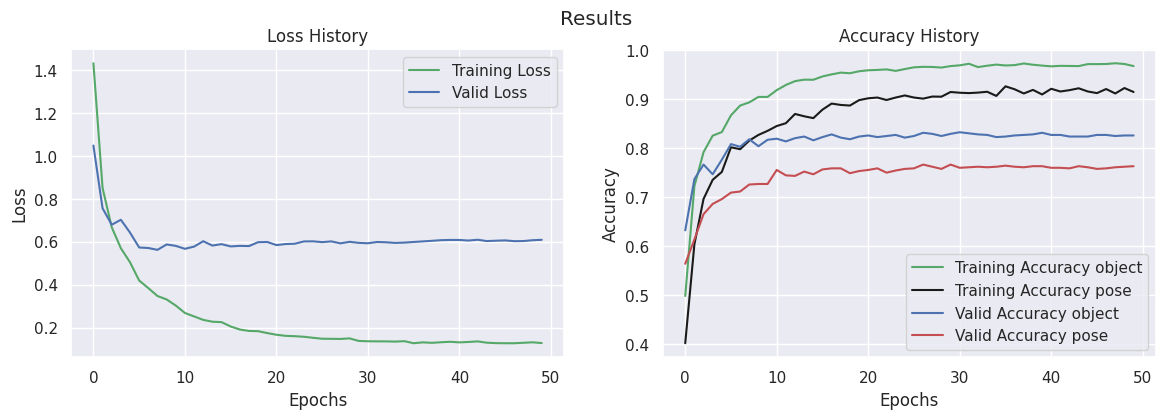

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history1 = trainer1.getHistory()
trainer1.showResults()

best model was trained at epoch: 31
with a validation loss of: 0.5929121 and a validation accuracy of: 83.25991034507751


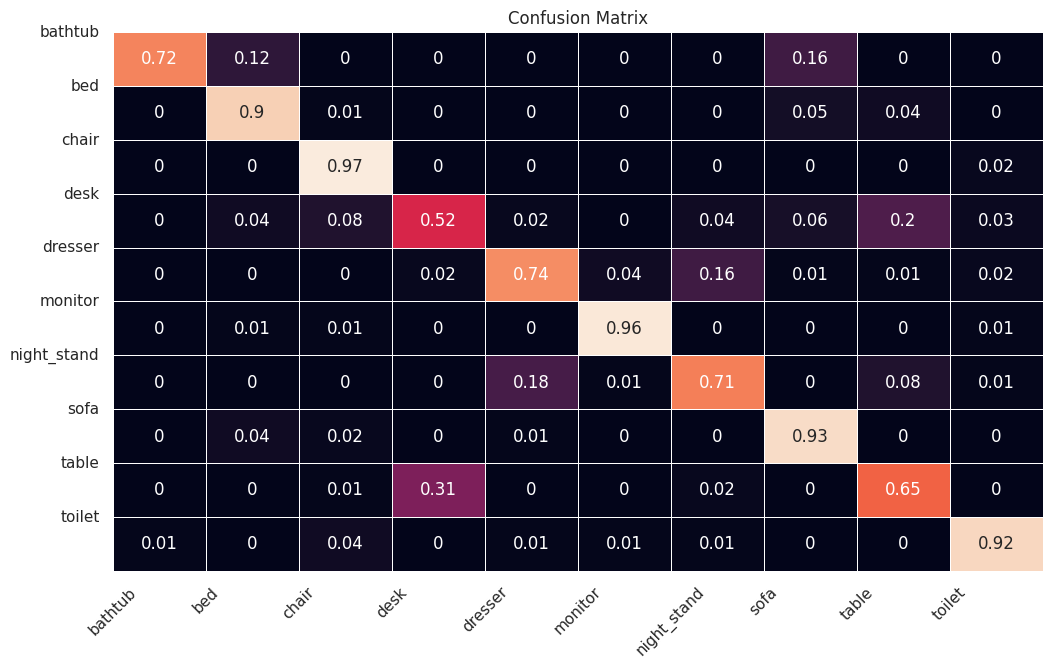

In [ ]:
trainer1.generateConfusionMatrix()

best model was trained at epoch: 31
with a validation loss of: 0.5929121 and a validation accuracy of: 83.25991034507751


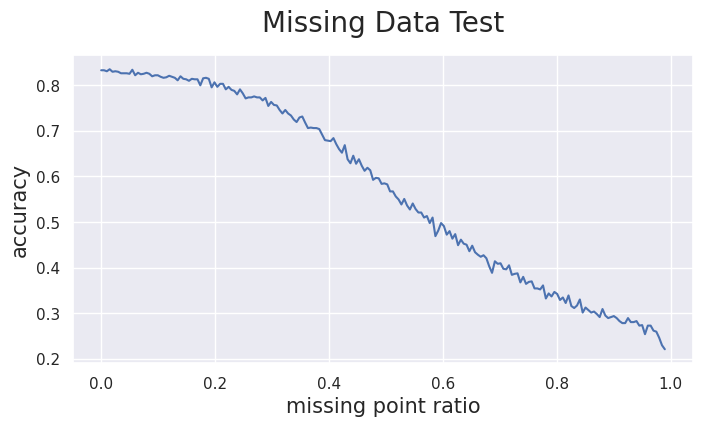

In [ ]:
trainer1.missing_data_test()

# BatcNormVoxNet

In [5]:
class BatchNormVoxNet(nn.Module):
    def __init__(self):
        super(BatchNormVoxNet, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('batch2', torch.nn.BatchNorm3d(64)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.3)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('batch3', torch.nn.BatchNorm3d(128)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2)),
            ('drop4', torch.nn.Dropout(p=0.3))            
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x1, x2
        return self.logsoftmax(x1), self.logsoftmax(x2)

**BatchNormVoxNet** Training 

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'BatchNormVoxNet'
}    

trainer2 = VoxNet_Trainer(training_hyperparameters)
trainer2.train()

model BatchNormVoxNet was chosen
62.359375


Train loss: 1.2345601320266724: : 62it [00:16,  3.68it/s]
29it [00:02, 12.25it/s]


epoch:  1 / 50
time: 19.26 seconds
train-loss: 1.57, train-acc-object: 44.51%, train-acc-pose: 34.00%
valid-loss: 1.41, valid-acc-object: 55.73%, train-acc-pose: 49.12%



Train loss: 0.8453148007392883: : 62it [00:17,  3.63it/s]
29it [00:03,  7.75it/s]


epoch:  2 / 50
time: 20.86 seconds
train-loss: 1.07, train-acc-object: 63.51%, train-acc-pose: 53.88%
valid-loss: 1.02, valid-acc-object: 63.44%, train-acc-pose: 57.49%



Train loss: 0.6898131966590881: : 62it [00:17,  3.57it/s]
29it [00:02, 12.30it/s]


epoch:  3 / 50
time: 19.73 seconds
train-loss: 0.87, train-acc-object: 70.41%, train-acc-pose: 61.97%
valid-loss: 0.83, valid-acc-object: 66.41%, train-acc-pose: 62.44%



Train loss: 0.5528572797775269: : 62it [00:17,  3.54it/s]
29it [00:03,  7.90it/s]


epoch:  4 / 50
time: 21.19 seconds
train-loss: 0.69, train-acc-object: 76.94%, train-acc-pose: 69.41%
valid-loss: 0.71, valid-acc-object: 72.25%, train-acc-pose: 68.50%



Train loss: 0.4964948892593384: : 62it [00:17,  3.53it/s]
29it [00:02, 12.23it/s]


epoch:  5 / 50
time: 19.94 seconds
train-loss: 0.56, train-acc-object: 82.26%, train-acc-pose: 73.79%
valid-loss: 0.63, valid-acc-object: 77.53%, train-acc-pose: 68.06%



Train loss: 0.39732813835144043: : 62it [00:17,  3.49it/s]
29it [00:03,  8.76it/s]


epoch:  6 / 50
time: 21.08 seconds
train-loss: 0.46, train-acc-object: 85.71%, train-acc-pose: 75.86%
valid-loss: 0.60, valid-acc-object: 78.85%, train-acc-pose: 69.49%



Train loss: 0.2801285982131958: : 62it [00:17,  3.58it/s]
29it [00:02, 12.11it/s]


epoch:  7 / 50
time: 19.74 seconds
train-loss: 0.43, train-acc-object: 86.84%, train-acc-pose: 78.00%
valid-loss: 0.65, valid-acc-object: 77.53%, train-acc-pose: 70.70%



Train loss: 0.2909589409828186: : 62it [00:17,  3.51it/s]
29it [00:02,  9.86it/s]


epoch:  8 / 50
time: 20.60 seconds
train-loss: 0.39, train-acc-object: 88.13%, train-acc-pose: 79.16%
valid-loss: 0.56, valid-acc-object: 82.05%, train-acc-pose: 72.80%



Train loss: 0.2745751738548279: : 62it [00:17,  3.61it/s]
29it [00:02, 12.61it/s]


epoch:  9 / 50
time: 19.50 seconds
train-loss: 0.36, train-acc-object: 88.89%, train-acc-pose: 80.49%
valid-loss: 0.55, valid-acc-object: 81.61%, train-acc-pose: 72.25%



Train loss: 0.3140104115009308: : 62it [00:17,  3.50it/s]
29it [00:03,  9.07it/s]


epoch: 10 / 50
time: 20.91 seconds
train-loss: 0.34, train-acc-object: 89.99%, train-acc-pose: 81.07%
valid-loss: 0.55, valid-acc-object: 82.27%, train-acc-pose: 72.14%



Train loss: 0.2837562561035156: : 62it [00:17,  3.58it/s]
29it [00:02, 13.11it/s]


epoch: 11 / 50
time: 19.55 seconds
train-loss: 0.30, train-acc-object: 91.05%, train-acc-pose: 82.06%
valid-loss: 0.55, valid-acc-object: 82.60%, train-acc-pose: 73.79%



Train loss: 0.22735941410064697: : 62it [00:18,  3.44it/s]
29it [00:02, 10.02it/s]


epoch: 12 / 50
time: 20.96 seconds
train-loss: 0.28, train-acc-object: 92.16%, train-acc-pose: 83.17%
valid-loss: 0.55, valid-acc-object: 83.37%, train-acc-pose: 74.23%



Train loss: 0.38177821040153503: : 62it [00:17,  3.52it/s]
29it [00:02, 12.33it/s]


epoch: 13 / 50
time: 19.97 seconds
train-loss: 0.27, train-acc-object: 92.49%, train-acc-pose: 84.15%
valid-loss: 0.55, valid-acc-object: 84.69%, train-acc-pose: 74.34%



Train loss: 0.2950103282928467: : 62it [00:17,  3.48it/s]
29it [00:02, 10.35it/s]


epoch: 14 / 50
time: 20.65 seconds
train-loss: 0.26, train-acc-object: 92.97%, train-acc-pose: 84.48%
valid-loss: 0.55, valid-acc-object: 83.81%, train-acc-pose: 73.13%



Train loss: 0.18497173488140106: : 62it [00:17,  3.60it/s]
29it [00:02, 12.00it/s]


epoch: 15 / 50
time: 19.65 seconds
train-loss: 0.25, train-acc-object: 93.07%, train-acc-pose: 84.58%
valid-loss: 0.54, valid-acc-object: 85.90%, train-acc-pose: 74.56%



Train loss: 0.30295640230178833: : 62it [00:18,  3.38it/s]
29it [00:02, 11.61it/s]


epoch: 16 / 50
time: 20.86 seconds
train-loss: 0.23, train-acc-object: 93.80%, train-acc-pose: 85.81%
valid-loss: 0.55, valid-acc-object: 84.80%, train-acc-pose: 75.44%



Train loss: 0.2140236794948578: : 62it [00:17,  3.48it/s]
29it [00:02, 11.94it/s]


epoch: 17 / 50
time: 20.25 seconds
train-loss: 0.23, train-acc-object: 93.88%, train-acc-pose: 85.23%
valid-loss: 0.55, valid-acc-object: 84.91%, train-acc-pose: 74.12%



Train loss: 0.253328800201416: : 62it [00:18,  3.32it/s]
29it [00:02, 11.83it/s]


epoch: 18 / 50
time: 21.15 seconds
train-loss: 0.22, train-acc-object: 94.38%, train-acc-pose: 85.86%
valid-loss: 0.55, valid-acc-object: 84.80%, train-acc-pose: 74.78%



Train loss: 0.22163346409797668: : 62it [00:17,  3.50it/s]
29it [00:02, 12.00it/s]


epoch: 19 / 50
time: 20.14 seconds
train-loss: 0.22, train-acc-object: 94.61%, train-acc-pose: 85.69%
valid-loss: 0.56, valid-acc-object: 85.02%, train-acc-pose: 73.79%



Train loss: 0.24934004247188568: : 62it [00:18,  3.41it/s]
29it [00:02, 12.14it/s]


epoch: 20 / 50
time: 20.58 seconds
train-loss: 0.21, train-acc-object: 94.71%, train-acc-pose: 85.81%
valid-loss: 0.55, valid-acc-object: 85.13%, train-acc-pose: 75.22%



Train loss: 0.26325908303260803: : 62it [00:17,  3.57it/s]
29it [00:02, 13.01it/s]


epoch: 21 / 50
time: 19.64 seconds
train-loss: 0.21, train-acc-object: 94.83%, train-acc-pose: 86.34%
valid-loss: 0.55, valid-acc-object: 85.02%, train-acc-pose: 75.33%



Train loss: 0.1594202220439911: : 62it [00:18,  3.38it/s]
29it [00:02, 12.20it/s]


epoch: 22 / 50
time: 20.74 seconds
train-loss: 0.21, train-acc-object: 94.73%, train-acc-pose: 86.69%
valid-loss: 0.55, valid-acc-object: 84.14%, train-acc-pose: 74.45%



Train loss: 0.12308148294687271: : 62it [00:17,  3.61it/s]
29it [00:02, 12.51it/s]


epoch: 23 / 50
time: 19.50 seconds
train-loss: 0.20, train-acc-object: 95.11%, train-acc-pose: 88.00%
valid-loss: 0.55, valid-acc-object: 84.69%, train-acc-pose: 74.89%



Train loss: 0.18925563991069794: : 62it [00:18,  3.42it/s]
29it [00:02, 11.83it/s]


epoch: 24 / 50
time: 20.61 seconds
train-loss: 0.20, train-acc-object: 95.06%, train-acc-pose: 87.42%
valid-loss: 0.55, valid-acc-object: 84.69%, train-acc-pose: 74.56%



Train loss: 0.16116684675216675: : 62it [00:17,  3.59it/s]
29it [00:02, 12.68it/s]


epoch: 25 / 50
time: 19.56 seconds
train-loss: 0.20, train-acc-object: 95.29%, train-acc-pose: 87.37%
valid-loss: 0.55, valid-acc-object: 84.25%, train-acc-pose: 75.00%



Train loss: 0.164267897605896: : 62it [00:18,  3.41it/s]
29it [00:02, 12.77it/s]


epoch: 26 / 50
time: 20.48 seconds
train-loss: 0.19, train-acc-object: 95.59%, train-acc-pose: 87.78%
valid-loss: 0.55, valid-acc-object: 85.02%, train-acc-pose: 74.89%



Train loss: 0.14745193719863892: : 62it [00:17,  3.58it/s]
29it [00:02, 12.09it/s]


epoch: 27 / 50
time: 19.75 seconds
train-loss: 0.19, train-acc-object: 95.39%, train-acc-pose: 87.40%
valid-loss: 0.56, valid-acc-object: 85.02%, train-acc-pose: 74.45%



Train loss: 0.1600980907678604: : 62it [00:18,  3.44it/s]
29it [00:02, 12.56it/s]


epoch: 28 / 50
time: 20.36 seconds
train-loss: 0.19, train-acc-object: 95.24%, train-acc-pose: 88.08%
valid-loss: 0.55, valid-acc-object: 85.13%, train-acc-pose: 75.00%



Train loss: 0.25276193022727966: : 62it [00:17,  3.61it/s]
29it [00:02, 12.37it/s]


epoch: 29 / 50
time: 19.51 seconds
train-loss: 0.19, train-acc-object: 95.34%, train-acc-pose: 88.03%
valid-loss: 0.56, valid-acc-object: 85.35%, train-acc-pose: 74.34%



Train loss: 0.13925951719284058: : 62it [00:17,  3.46it/s]
29it [00:02, 12.64it/s]


epoch: 30 / 50
time: 20.21 seconds
train-loss: 0.19, train-acc-object: 95.24%, train-acc-pose: 87.50%
valid-loss: 0.56, valid-acc-object: 84.69%, train-acc-pose: 74.78%



Train loss: 0.21926192939281464: : 62it [00:17,  3.59it/s]
29it [00:02, 12.35it/s]


epoch: 31 / 50
time: 19.66 seconds
train-loss: 0.19, train-acc-object: 95.79%, train-acc-pose: 87.20%
valid-loss: 0.56, valid-acc-object: 84.69%, train-acc-pose: 74.56%



Train loss: 0.21064189076423645: : 62it [00:18,  3.44it/s]
29it [00:02, 12.39it/s]


epoch: 32 / 50
time: 20.39 seconds
train-loss: 0.18, train-acc-object: 95.51%, train-acc-pose: 88.23%
valid-loss: 0.56, valid-acc-object: 84.91%, train-acc-pose: 75.22%



Train loss: 0.12192472815513611: : 62it [00:17,  3.61it/s]
29it [00:02, 12.58it/s]


epoch: 33 / 50
time: 19.50 seconds
train-loss: 0.18, train-acc-object: 95.92%, train-acc-pose: 88.53%
valid-loss: 0.56, valid-acc-object: 85.13%, train-acc-pose: 74.67%



Train loss: 0.11187963932752609: : 62it [00:18,  3.43it/s]
29it [00:02, 12.29it/s]


epoch: 34 / 50
time: 20.44 seconds
train-loss: 0.19, train-acc-object: 95.51%, train-acc-pose: 87.37%
valid-loss: 0.56, valid-acc-object: 85.13%, train-acc-pose: 74.67%



Train loss: 0.13437877595424652: : 62it [00:17,  3.62it/s]
29it [00:02, 12.92it/s]


epoch: 35 / 50
time: 19.39 seconds
train-loss: 0.19, train-acc-object: 95.67%, train-acc-pose: 87.60%
valid-loss: 0.56, valid-acc-object: 85.02%, train-acc-pose: 74.78%



Train loss: 0.15937942266464233: : 62it [00:17,  3.45it/s]
29it [00:02, 12.76it/s]


epoch: 36 / 50
time: 20.24 seconds
train-loss: 0.18, train-acc-object: 95.64%, train-acc-pose: 88.18%
valid-loss: 0.56, valid-acc-object: 85.02%, train-acc-pose: 75.11%



Train loss: 0.33684563636779785: : 62it [00:17,  3.62it/s]
29it [00:02, 12.65it/s]


epoch: 37 / 50
time: 19.44 seconds
train-loss: 0.19, train-acc-object: 95.11%, train-acc-pose: 87.95%
valid-loss: 0.56, valid-acc-object: 85.02%, train-acc-pose: 74.78%



Train loss: 0.19050084054470062: : 62it [00:17,  3.48it/s]
29it [00:02, 12.82it/s]


epoch: 38 / 50
time: 20.11 seconds
train-loss: 0.18, train-acc-object: 95.92%, train-acc-pose: 87.98%
valid-loss: 0.56, valid-acc-object: 84.80%, train-acc-pose: 75.22%



Train loss: 0.22622108459472656: : 62it [00:16,  3.65it/s]
29it [00:02, 12.52it/s]


epoch: 39 / 50
time: 19.33 seconds
train-loss: 0.19, train-acc-object: 95.31%, train-acc-pose: 88.10%
valid-loss: 0.56, valid-acc-object: 84.80%, train-acc-pose: 75.00%



Train loss: 0.1772429347038269: : 62it [00:17,  3.45it/s]
29it [00:02, 12.38it/s]


epoch: 40 / 50
time: 20.31 seconds
train-loss: 0.18, train-acc-object: 96.14%, train-acc-pose: 88.21%
valid-loss: 0.56, valid-acc-object: 85.02%, train-acc-pose: 74.89%



Train loss: 0.19984285533428192: : 62it [00:17,  3.61it/s]
29it [00:02, 12.58it/s]


epoch: 41 / 50
time: 19.47 seconds
train-loss: 0.19, train-acc-object: 95.79%, train-acc-pose: 87.30%
valid-loss: 0.56, valid-acc-object: 84.91%, train-acc-pose: 75.22%



Train loss: 0.20333923399448395: : 62it [00:17,  3.45it/s]
29it [00:02, 12.51it/s]


epoch: 42 / 50
time: 20.29 seconds
train-loss: 0.18, train-acc-object: 96.04%, train-acc-pose: 88.31%
valid-loss: 0.56, valid-acc-object: 84.91%, train-acc-pose: 75.22%



Train loss: 0.19714882969856262: : 62it [00:17,  3.59it/s]
29it [00:02, 12.58it/s]


epoch: 43 / 50
time: 19.62 seconds
train-loss: 0.18, train-acc-object: 96.30%, train-acc-pose: 88.38%
valid-loss: 0.56, valid-acc-object: 84.91%, train-acc-pose: 75.11%



Train loss: 0.1306784451007843: : 62it [00:17,  3.46it/s]
29it [00:02, 12.49it/s]


epoch: 44 / 50
time: 20.27 seconds
train-loss: 0.18, train-acc-object: 96.09%, train-acc-pose: 88.08%
valid-loss: 0.56, valid-acc-object: 84.91%, train-acc-pose: 75.00%



Train loss: 0.18755865097045898: : 62it [00:17,  3.62it/s]
29it [00:02, 12.42it/s]


epoch: 45 / 50
time: 19.48 seconds
train-loss: 0.19, train-acc-object: 95.87%, train-acc-pose: 88.16%
valid-loss: 0.57, valid-acc-object: 84.91%, train-acc-pose: 75.00%



Train loss: 0.1569032073020935: : 62it [00:18,  3.44it/s]
29it [00:02, 12.38it/s]


epoch: 46 / 50
time: 20.40 seconds
train-loss: 0.18, train-acc-object: 95.89%, train-acc-pose: 88.48%
valid-loss: 0.57, valid-acc-object: 84.91%, train-acc-pose: 74.89%



Train loss: 0.13120733201503754: : 62it [00:17,  3.61it/s]
29it [00:02, 12.46it/s]


epoch: 47 / 50
time: 19.50 seconds
train-loss: 0.18, train-acc-object: 96.09%, train-acc-pose: 88.05%
valid-loss: 0.56, valid-acc-object: 84.91%, train-acc-pose: 74.56%



Train loss: 0.1963944435119629: : 62it [00:17,  3.45it/s]
29it [00:02, 12.26it/s]


epoch: 48 / 50
time: 20.35 seconds
train-loss: 0.18, train-acc-object: 95.79%, train-acc-pose: 88.33%
valid-loss: 0.57, valid-acc-object: 84.91%, train-acc-pose: 74.78%



Train loss: 0.1888425499200821: : 62it [00:17,  3.60it/s]
29it [00:02, 11.66it/s]


epoch: 49 / 50
time: 19.72 seconds
train-loss: 0.18, train-acc-object: 95.74%, train-acc-pose: 88.26%
valid-loss: 0.56, valid-acc-object: 85.02%, train-acc-pose: 74.89%



Train loss: 0.1508789360523224: : 62it [00:17,  3.45it/s]
29it [00:02, 12.42it/s]

epoch: 50 / 50
time: 20.33 seconds
train-loss: 0.18, train-acc-object: 95.87%, train-acc-pose: 88.03%
valid-loss: 0.56, valid-acc-object: 85.02%, train-acc-pose: 74.89%



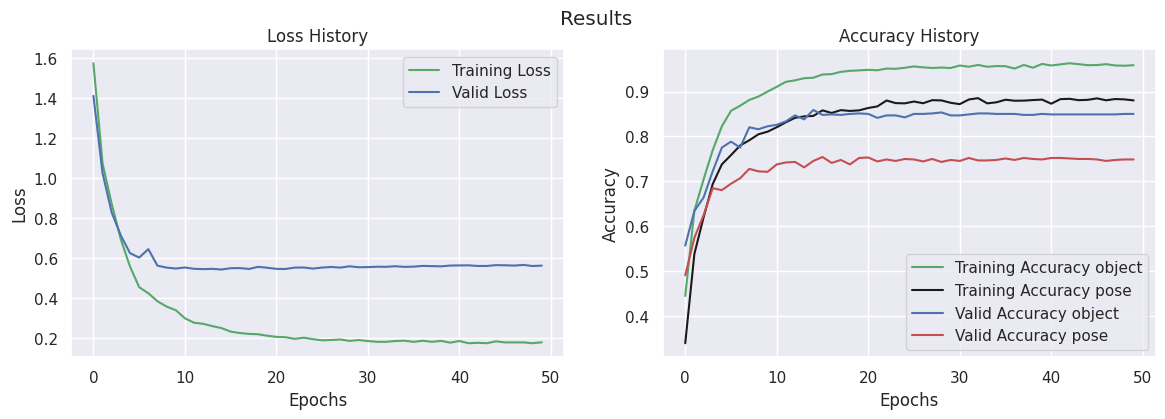

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history2 = trainer2.getHistory()
trainer2.showResults()

best model was trained at epoch: 15
with a validation loss of: 0.5441153 and a validation accuracy of: 85.90308427810669


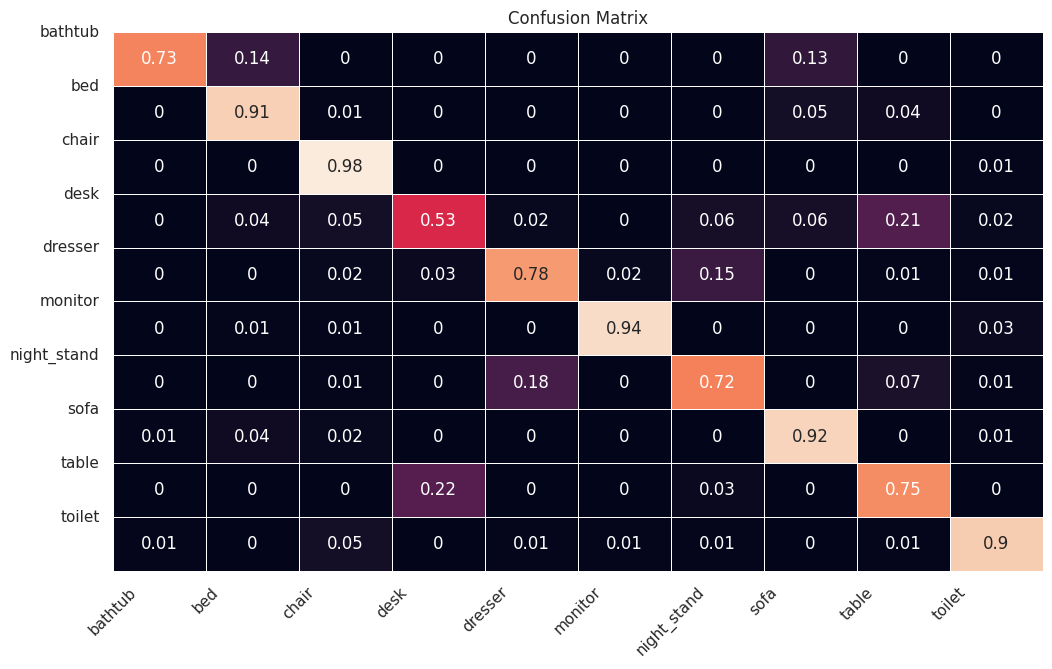

In [ ]:
trainer2.generateConfusionMatrix()

best model was trained at epoch: 15
with a validation loss of: 0.5441153 and a validation accuracy of: 85.90308427810669


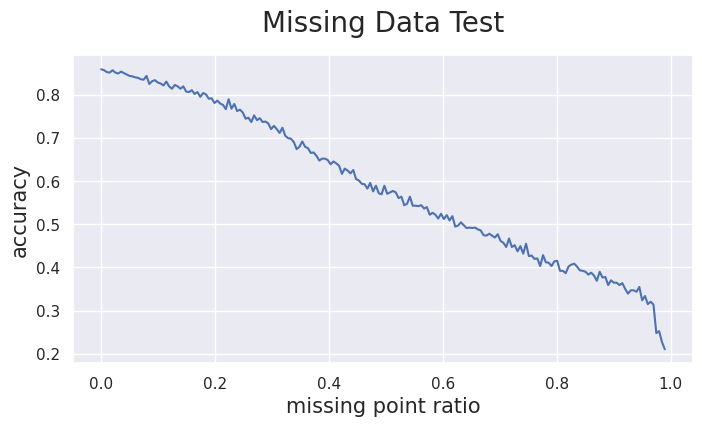

In [ ]:
trainer2.missing_data_test()

# DMPVoxNet (double-max-pooling VoxNet)

In [6]:
class DMPVoxNet(nn.Module):
    def __init__(self):
        super(DMPVoxNet, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=1)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.2)),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('pool3', torch.nn.MaxPool3d(2)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256,kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('drop4', torch.nn.Dropout(p=0.4)),
            ('pool4', torch.nn.MaxPool3d(2))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x1, x2
        return self.logsoftmax(x1), self.logsoftmax(x2)

**DMPVoxNet** training

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'DMPVoxNet'
}    

trainer3 = VoxNet_Trainer(training_hyperparameters)
trainer3.train()

model DMPVoxNet was choosen
62.359375


Train loss: 1.1273289918899536: : 62it [00:27,  2.28it/s]
29it [00:02, 11.02it/s]


epoch:  1 / 50
time: 29.86 seconds
train-loss: 1.59, train-acc-object: 46.35%, train-acc-pose: 33.59%
valid-loss: 1.60, valid-acc-object: 60.90%, train-acc-pose: 50.44%



Train loss: 0.8075911402702332: : 62it [00:27,  2.29it/s]
29it [00:02, 10.76it/s]


epoch:  2 / 50
time: 29.77 seconds
train-loss: 0.99, train-acc-object: 66.48%, train-acc-pose: 56.10%
valid-loss: 1.15, valid-acc-object: 67.18%, train-acc-pose: 59.58%



Train loss: 0.6080558896064758: : 62it [00:26,  2.31it/s]
29it [00:02, 10.87it/s]


epoch:  3 / 50
time: 29.50 seconds
train-loss: 0.75, train-acc-object: 74.67%, train-acc-pose: 67.14%
valid-loss: 1.05, valid-acc-object: 73.35%, train-acc-pose: 63.00%



Train loss: 0.6561884880065918: : 62it [00:26,  2.30it/s]
29it [00:03,  7.48it/s]


epoch:  4 / 50
time: 30.81 seconds
train-loss: 0.61, train-acc-object: 80.22%, train-acc-pose: 71.85%
valid-loss: 0.92, valid-acc-object: 75.55%, train-acc-pose: 68.94%



Train loss: 0.4698568880558014: : 62it [00:27,  2.28it/s]
29it [00:02, 10.61it/s]


epoch:  5 / 50
time: 29.92 seconds
train-loss: 0.52, train-acc-object: 83.29%, train-acc-pose: 74.34%
valid-loss: 0.79, valid-acc-object: 79.19%, train-acc-pose: 66.85%



Train loss: 0.40807950496673584: : 62it [00:26,  2.30it/s]
29it [00:02, 10.52it/s]


epoch:  6 / 50
time: 29.71 seconds
train-loss: 0.43, train-acc-object: 86.06%, train-acc-pose: 77.95%
valid-loss: 0.69, valid-acc-object: 82.27%, train-acc-pose: 69.05%



Train loss: 0.3516576290130615: : 62it [00:26,  2.30it/s]
29it [00:02,  9.95it/s]


epoch:  7 / 50
time: 29.90 seconds
train-loss: 0.37, train-acc-object: 88.94%, train-acc-pose: 78.58%
valid-loss: 0.64, valid-acc-object: 83.26%, train-acc-pose: 71.59%



Train loss: 0.22676464915275574: : 62it [00:27,  2.29it/s]
29it [00:03,  8.41it/s]


epoch:  8 / 50
time: 30.60 seconds
train-loss: 0.36, train-acc-object: 89.49%, train-acc-pose: 79.23%
valid-loss: 0.63, valid-acc-object: 83.59%, train-acc-pose: 71.59%



Train loss: 0.34334152936935425: : 62it [00:26,  2.30it/s]
29it [00:02, 10.81it/s]


epoch:  9 / 50
time: 29.68 seconds
train-loss: 0.32, train-acc-object: 90.60%, train-acc-pose: 81.35%
valid-loss: 0.59, valid-acc-object: 81.72%, train-acc-pose: 72.58%



Train loss: 0.37961429357528687: : 62it [00:26,  2.30it/s]
29it [00:02, 10.75it/s]


epoch: 10 / 50
time: 29.68 seconds
train-loss: 0.32, train-acc-object: 90.57%, train-acc-pose: 81.05%
valid-loss: 0.60, valid-acc-object: 81.61%, train-acc-pose: 72.80%



Train loss: 0.13358867168426514: : 62it [00:26,  2.30it/s]
29it [00:03,  9.13it/s]


epoch: 11 / 50
time: 30.14 seconds
train-loss: 0.27, train-acc-object: 92.19%, train-acc-pose: 83.72%
valid-loss: 0.55, valid-acc-object: 83.59%, train-acc-pose: 74.67%



Train loss: 0.19667644798755646: : 62it [00:27,  2.29it/s]
29it [00:03,  9.58it/s]


epoch: 12 / 50
time: 30.15 seconds
train-loss: 0.24, train-acc-object: 93.47%, train-acc-pose: 83.87%
valid-loss: 0.53, valid-acc-object: 84.47%, train-acc-pose: 74.23%



Train loss: 0.23798523843288422: : 62it [00:26,  2.30it/s]
29it [00:02, 10.65it/s]


epoch: 13 / 50
time: 29.71 seconds
train-loss: 0.24, train-acc-object: 93.45%, train-acc-pose: 84.12%
valid-loss: 0.52, valid-acc-object: 84.58%, train-acc-pose: 74.01%



Train loss: 0.21780988574028015: : 62it [00:26,  2.30it/s]
29it [00:02, 10.74it/s]


epoch: 14 / 50
time: 29.71 seconds
train-loss: 0.23, train-acc-object: 93.88%, train-acc-pose: 85.03%
valid-loss: 0.52, valid-acc-object: 82.60%, train-acc-pose: 74.45%



Train loss: 0.2821773886680603: : 62it [00:27,  2.29it/s]
29it [00:03,  8.07it/s]


epoch: 15 / 50
time: 30.63 seconds
train-loss: 0.23, train-acc-object: 94.25%, train-acc-pose: 84.80%
valid-loss: 0.51, valid-acc-object: 84.47%, train-acc-pose: 74.56%



Train loss: 0.23706713318824768: : 62it [00:27,  2.28it/s]
29it [00:02, 10.86it/s]


epoch: 16 / 50
time: 29.83 seconds
train-loss: 0.20, train-acc-object: 94.91%, train-acc-pose: 86.34%
valid-loss: 0.50, valid-acc-object: 84.69%, train-acc-pose: 74.89%



Train loss: 0.19524714350700378: : 62it [00:26,  2.30it/s]
29it [00:02, 10.95it/s]


epoch: 17 / 50
time: 29.60 seconds
train-loss: 0.19, train-acc-object: 95.04%, train-acc-pose: 86.69%
valid-loss: 0.49, valid-acc-object: 84.36%, train-acc-pose: 75.22%



Train loss: 0.14979547262191772: : 62it [00:26,  2.30it/s]
29it [00:02, 10.93it/s]


epoch: 18 / 50
time: 29.65 seconds
train-loss: 0.18, train-acc-object: 95.92%, train-acc-pose: 87.02%
valid-loss: 0.49, valid-acc-object: 85.35%, train-acc-pose: 75.99%



Train loss: 0.13602063059806824: : 62it [00:27,  2.29it/s]
29it [00:03,  7.66it/s]


epoch: 19 / 50
time: 30.84 seconds
train-loss: 0.18, train-acc-object: 95.59%, train-acc-pose: 86.39%
valid-loss: 0.48, valid-acc-object: 84.91%, train-acc-pose: 75.99%



Train loss: 0.11800692975521088: : 62it [00:26,  2.30it/s]
29it [00:02, 10.57it/s]


epoch: 20 / 50
time: 29.70 seconds
train-loss: 0.18, train-acc-object: 95.74%, train-acc-pose: 86.84%
valid-loss: 0.48, valid-acc-object: 84.91%, train-acc-pose: 76.54%



Train loss: 0.11597032845020294: : 62it [00:27,  2.27it/s]
29it [00:02, 10.60it/s]


epoch: 21 / 50
time: 30.05 seconds
train-loss: 0.16, train-acc-object: 96.32%, train-acc-pose: 87.80%
valid-loss: 0.47, valid-acc-object: 85.57%, train-acc-pose: 76.87%



Train loss: 0.16621525585651398: : 62it [00:27,  2.24it/s]
29it [00:06,  4.17it/s]


epoch: 22 / 50
time: 34.71 seconds
train-loss: 0.16, train-acc-object: 96.62%, train-acc-pose: 88.58%
valid-loss: 0.47, valid-acc-object: 84.91%, train-acc-pose: 76.43%



Train loss: 0.1939355880022049: : 62it [00:31,  2.00it/s]
29it [00:02, 10.67it/s]


epoch: 23 / 50
time: 33.75 seconds
train-loss: 0.16, train-acc-object: 96.14%, train-acc-pose: 87.78%
valid-loss: 0.47, valid-acc-object: 84.91%, train-acc-pose: 76.65%



Train loss: 0.13341709971427917: : 62it [00:27,  2.28it/s]
29it [00:03,  8.85it/s]


epoch: 24 / 50
time: 30.46 seconds
train-loss: 0.16, train-acc-object: 96.19%, train-acc-pose: 88.71%
valid-loss: 0.47, valid-acc-object: 85.13%, train-acc-pose: 76.54%



Train loss: 0.1480737328529358: : 62it [00:27,  2.27it/s]
29it [00:02,  9.80it/s]


epoch: 25 / 50
time: 30.35 seconds
train-loss: 0.15, train-acc-object: 96.19%, train-acc-pose: 88.71%
valid-loss: 0.47, valid-acc-object: 84.80%, train-acc-pose: 76.10%



Train loss: 0.22454407811164856: : 62it [00:27,  2.23it/s]
29it [00:02, 10.79it/s]


epoch: 26 / 50
time: 30.55 seconds
train-loss: 0.16, train-acc-object: 96.40%, train-acc-pose: 88.18%
valid-loss: 0.47, valid-acc-object: 85.02%, train-acc-pose: 76.43%



Train loss: 0.21555334329605103: : 62it [00:26,  2.30it/s]
29it [00:02, 10.83it/s]


epoch: 27 / 50
time: 29.60 seconds
train-loss: 0.15, train-acc-object: 96.45%, train-acc-pose: 88.66%
valid-loss: 0.47, valid-acc-object: 85.35%, train-acc-pose: 76.54%



Train loss: 0.1408815234899521: : 62it [00:27,  2.30it/s]
29it [00:03,  7.46it/s]


epoch: 28 / 50
time: 30.92 seconds
train-loss: 0.15, train-acc-object: 96.77%, train-acc-pose: 88.96%
valid-loss: 0.47, valid-acc-object: 84.58%, train-acc-pose: 76.65%



Train loss: 0.1780412197113037: : 62it [00:27,  2.23it/s]
29it [00:02, 10.74it/s]


epoch: 29 / 50
time: 30.57 seconds
train-loss: 0.15, train-acc-object: 96.55%, train-acc-pose: 88.61%
valid-loss: 0.46, valid-acc-object: 84.58%, train-acc-pose: 76.54%



Train loss: 0.15930697321891785: : 62it [00:27,  2.29it/s]
29it [00:02, 10.68it/s]


epoch: 30 / 50
time: 29.81 seconds
train-loss: 0.14, train-acc-object: 97.05%, train-acc-pose: 89.09%
valid-loss: 0.47, valid-acc-object: 84.58%, train-acc-pose: 76.43%



Train loss: 0.14322605729103088: : 62it [00:27,  2.29it/s]
29it [00:03,  8.07it/s]


epoch: 31 / 50
time: 30.69 seconds
train-loss: 0.15, train-acc-object: 97.03%, train-acc-pose: 88.61%
valid-loss: 0.46, valid-acc-object: 85.02%, train-acc-pose: 77.31%



Train loss: 0.12215004861354828: : 62it [00:27,  2.26it/s]
29it [00:02, 10.57it/s]


epoch: 32 / 50
time: 30.22 seconds
train-loss: 0.14, train-acc-object: 97.15%, train-acc-pose: 89.01%
valid-loss: 0.46, valid-acc-object: 85.35%, train-acc-pose: 77.42%



Train loss: 0.14469470083713531: : 62it [00:27,  2.30it/s]
29it [00:02, 10.72it/s]


epoch: 33 / 50
time: 29.73 seconds
train-loss: 0.14, train-acc-object: 96.95%, train-acc-pose: 89.31%
valid-loss: 0.46, valid-acc-object: 85.13%, train-acc-pose: 77.20%



Train loss: 0.1441120207309723: : 62it [00:27,  2.29it/s]
29it [00:02, 10.64it/s]


epoch: 34 / 50
time: 29.77 seconds
train-loss: 0.14, train-acc-object: 97.13%, train-acc-pose: 89.34%
valid-loss: 0.46, valid-acc-object: 85.35%, train-acc-pose: 76.76%



Train loss: 0.1401299089193344: : 62it [00:27,  2.29it/s]
29it [00:03,  7.48it/s]


epoch: 35 / 50
time: 30.94 seconds
train-loss: 0.14, train-acc-object: 97.13%, train-acc-pose: 89.54%
valid-loss: 0.46, valid-acc-object: 85.13%, train-acc-pose: 76.76%



Train loss: 0.09707344323396683: : 62it [00:27,  2.29it/s]
29it [00:02, 10.84it/s]


epoch: 36 / 50
time: 29.74 seconds
train-loss: 0.14, train-acc-object: 97.05%, train-acc-pose: 89.36%
valid-loss: 0.46, valid-acc-object: 85.02%, train-acc-pose: 76.98%



Train loss: 0.14591741561889648: : 62it [00:27,  2.29it/s]
29it [00:02, 10.84it/s]


epoch: 37 / 50
time: 29.76 seconds
train-loss: 0.14, train-acc-object: 97.18%, train-acc-pose: 89.57%
valid-loss: 0.46, valid-acc-object: 85.13%, train-acc-pose: 77.31%



Train loss: 0.14861853420734406: : 62it [00:27,  2.26it/s]
29it [00:03,  8.76it/s]


epoch: 38 / 50
time: 30.70 seconds
train-loss: 0.14, train-acc-object: 97.33%, train-acc-pose: 89.69%
valid-loss: 0.46, valid-acc-object: 85.24%, train-acc-pose: 77.09%



Train loss: 0.14719228446483612: : 62it [00:27,  2.26it/s]
29it [00:02,  9.67it/s]


epoch: 39 / 50
time: 30.49 seconds
train-loss: 0.14, train-acc-object: 96.95%, train-acc-pose: 89.42%
valid-loss: 0.46, valid-acc-object: 85.24%, train-acc-pose: 77.31%



Train loss: 0.15298046171665192: : 62it [00:27,  2.27it/s]
29it [00:02, 10.57it/s]


epoch: 40 / 50
time: 30.08 seconds
train-loss: 0.14, train-acc-object: 97.10%, train-acc-pose: 89.24%
valid-loss: 0.46, valid-acc-object: 85.13%, train-acc-pose: 77.20%



Train loss: 0.13637647032737732: : 62it [00:27,  2.29it/s]
29it [00:02, 10.60it/s]


epoch: 41 / 50
time: 29.84 seconds
train-loss: 0.13, train-acc-object: 97.35%, train-acc-pose: 89.54%
valid-loss: 0.46, valid-acc-object: 85.46%, train-acc-pose: 77.09%



Train loss: 0.12804019451141357: : 62it [00:27,  2.28it/s]
29it [00:03,  7.62it/s]


epoch: 42 / 50
time: 31.00 seconds
train-loss: 0.14, train-acc-object: 97.05%, train-acc-pose: 88.73%
valid-loss: 0.46, valid-acc-object: 85.35%, train-acc-pose: 77.09%



Train loss: 0.11669615656137466: : 62it [00:27,  2.29it/s]
29it [00:02, 10.52it/s]


epoch: 43 / 50
time: 29.85 seconds
train-loss: 0.14, train-acc-object: 97.25%, train-acc-pose: 89.14%
valid-loss: 0.46, valid-acc-object: 85.46%, train-acc-pose: 77.20%



Train loss: 0.10537521541118622: : 62it [00:27,  2.28it/s]
29it [00:02, 10.72it/s]


epoch: 44 / 50
time: 29.87 seconds
train-loss: 0.14, train-acc-object: 97.18%, train-acc-pose: 90.05%
valid-loss: 0.46, valid-acc-object: 85.46%, train-acc-pose: 77.31%



Train loss: 0.10325614362955093: : 62it [00:27,  2.28it/s]
29it [00:03,  8.22it/s]


epoch: 45 / 50
time: 30.79 seconds
train-loss: 0.14, train-acc-object: 97.23%, train-acc-pose: 88.76%
valid-loss: 0.46, valid-acc-object: 85.35%, train-acc-pose: 77.53%



Train loss: 0.10219773650169373: : 62it [00:27,  2.27it/s]
29it [00:02, 10.68it/s]


epoch: 46 / 50
time: 30.08 seconds
train-loss: 0.13, train-acc-object: 97.58%, train-acc-pose: 89.82%
valid-loss: 0.46, valid-acc-object: 85.46%, train-acc-pose: 77.53%



Train loss: 0.11354076862335205: : 62it [00:27,  2.27it/s]
29it [00:02, 10.37it/s]


epoch: 47 / 50
time: 30.13 seconds
train-loss: 0.14, train-acc-object: 97.40%, train-acc-pose: 89.24%
valid-loss: 0.46, valid-acc-object: 85.35%, train-acc-pose: 77.53%



Train loss: 0.16262459754943848: : 62it [00:27,  2.26it/s]
29it [00:02, 10.43it/s]


epoch: 48 / 50
time: 30.22 seconds
train-loss: 0.14, train-acc-object: 96.47%, train-acc-pose: 89.69%
valid-loss: 0.46, valid-acc-object: 85.24%, train-acc-pose: 77.64%



Train loss: 0.11792679131031036: : 62it [00:27,  2.27it/s]
29it [00:03,  8.37it/s]


epoch: 49 / 50
time: 30.82 seconds
train-loss: 0.14, train-acc-object: 96.85%, train-acc-pose: 89.24%
valid-loss: 0.46, valid-acc-object: 85.35%, train-acc-pose: 77.42%



Train loss: 0.13765716552734375: : 62it [00:27,  2.26it/s]
29it [00:02, 10.56it/s]

epoch: 50 / 50
time: 30.17 seconds
train-loss: 0.14, train-acc-object: 96.67%, train-acc-pose: 89.42%
valid-loss: 0.46, valid-acc-object: 85.46%, train-acc-pose: 77.42%



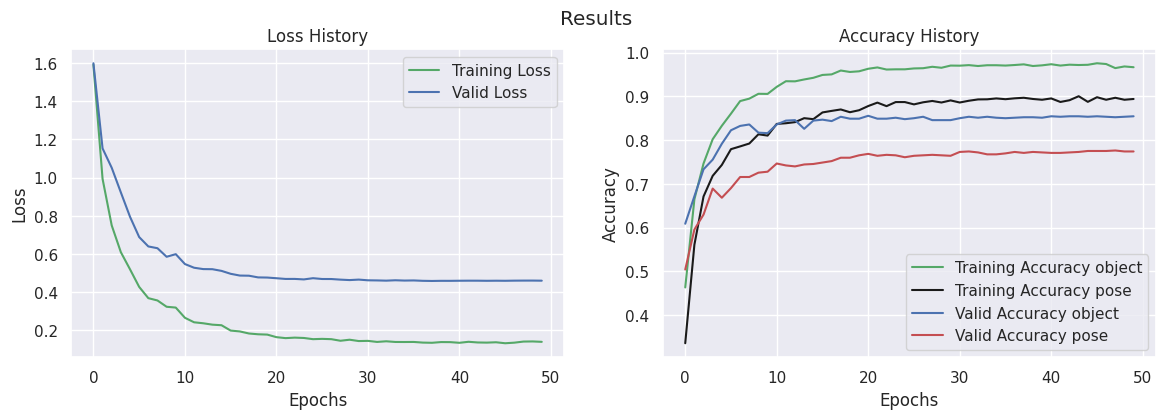

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history3 = trainer3.getHistory()
trainer3.showResults()

best model was trained at epoch: 21
with a validation loss of: 0.4731498 and a validation accuracy of: 85.57268977165222


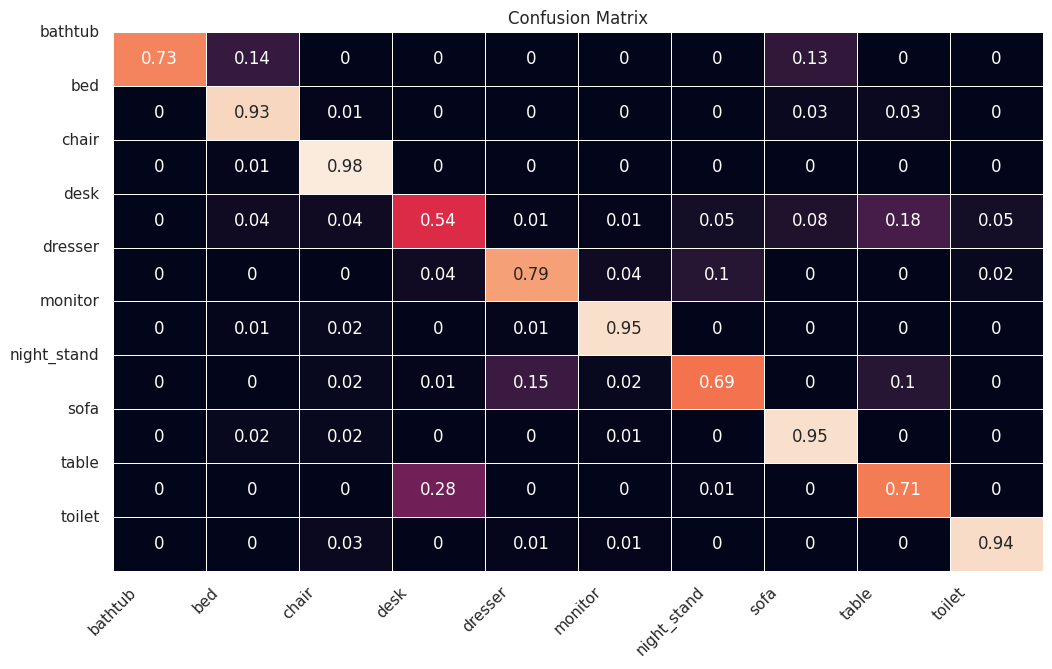

In [ ]:
trainer3.generateConfusionMatrix()

best model was trained at epoch: 21
with a validation loss of: 0.4731498 and a validation accuracy of: 85.57268977165222


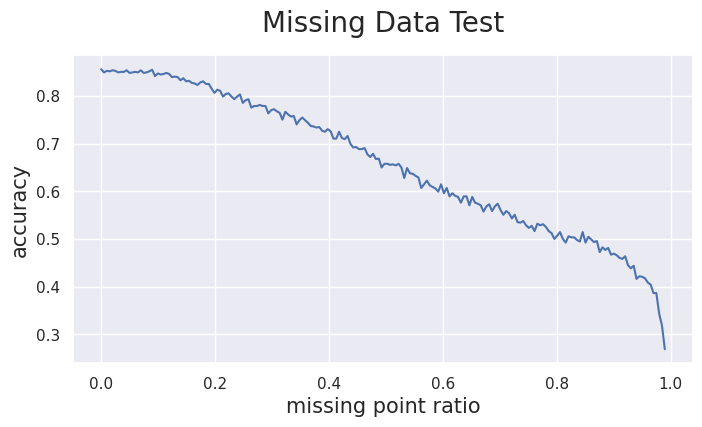

In [ ]:
trainer3.missing_data_test()

# VoxNet model comparison

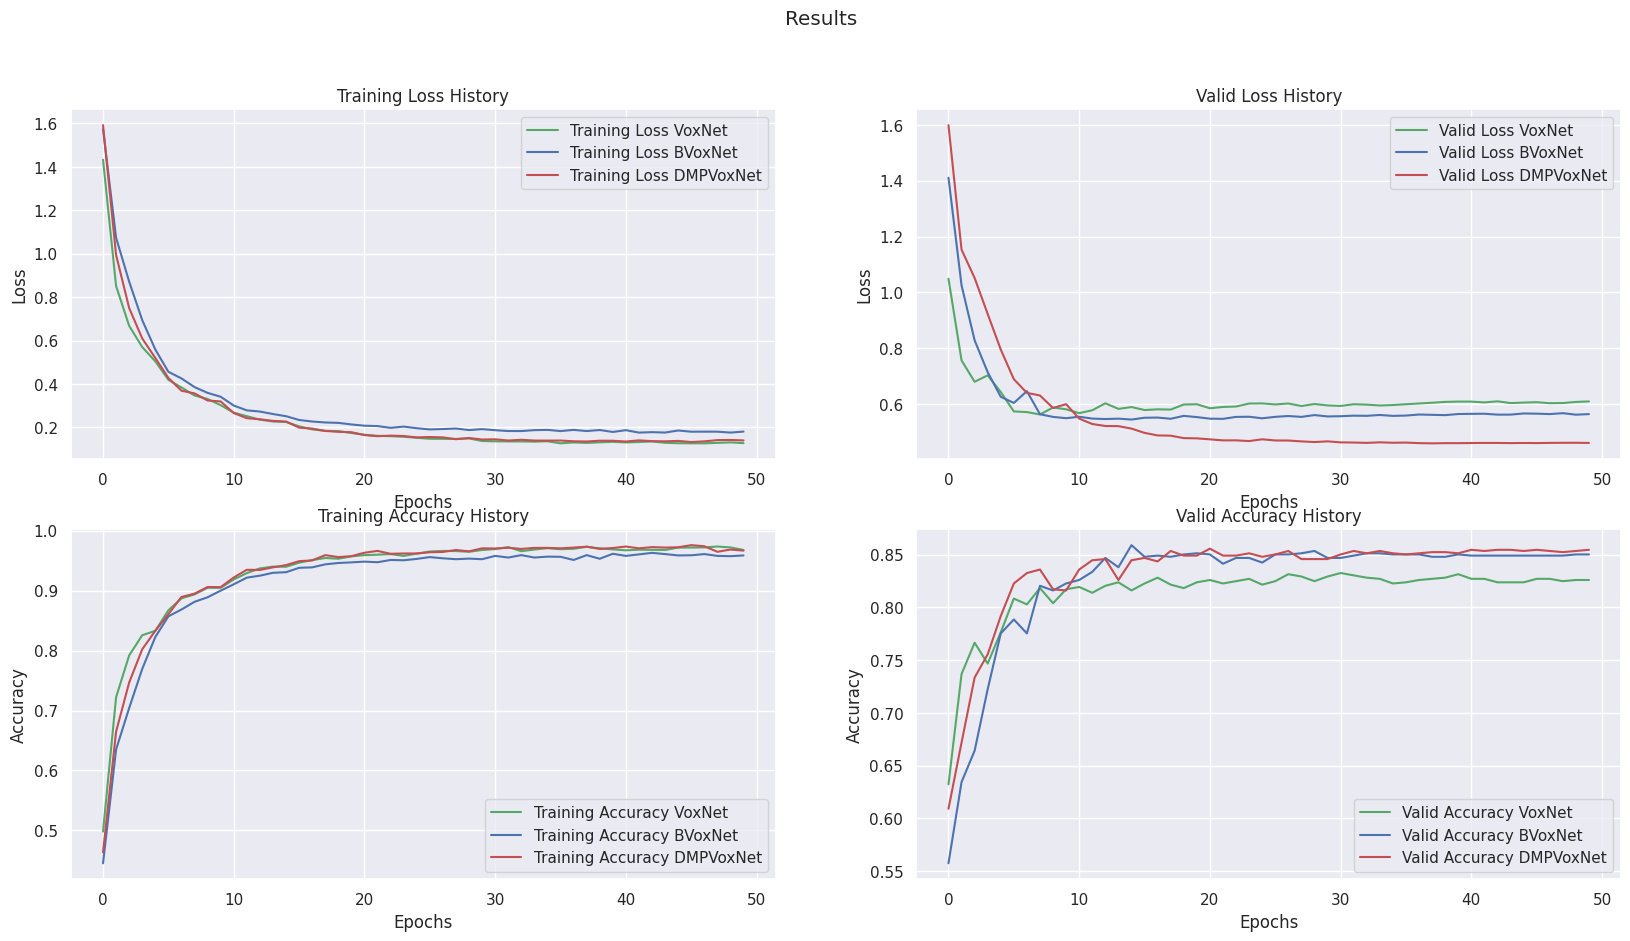

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

eps = range(0, len(history1["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')
        
ax[0,0].plot(eps, smooth(history1["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0,0].plot(eps, smooth(history2["train_loss"].cpu()), 'b', label='Training Loss BVoxNet')
ax[0,0].plot(eps, smooth(history3["train_loss"].cpu()), 'r', label='Training Loss DMPVoxNet')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()
        
ax[0,1].plot(eps, smooth(history1["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet')
ax[0,1].plot(eps, smooth(history2["valid_loss"].cpu()), 'b', label='Valid Loss BVoxNet')
ax[0,1].plot(eps, smooth(history3["valid_loss"].cpu()), 'r', label='Valid Loss DMPVoxNet')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history1["train_acc1"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[1,0].plot(eps, smooth(history2["train_acc1"].cpu()), 'b', label='Training Accuracy BVoxNet')
ax[1,0].plot(eps, smooth(history3["train_acc1"].cpu()), 'r', label='Training Accuracy DMPVoxNet')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history1["valid_acc1"].cpu()), 'g', label='Valid Accuracy VoxNet')
ax[1,1].plot(eps, smooth(history2["valid_acc1"].cpu()), 'b', label='Valid Accuracy BVoxNet')
ax[1,1].plot(eps, smooth(history3["valid_acc1"].cpu()), 'r', label='Valid Accuracy DMPVoxNet')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()

# Data Augmentation



In [7]:
ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X_a = {'train': [], 'test': []}
Y_a = {'train': [], 'test': []}
Z_a = {'train': [], 'test': []}

for label1, cl in enumerate(CLASSES):
    for label2, rot in enumerate(ROTATIONS):
        split = 'train'
        examples_dir = os.path.join(ROOT, cl, split)
        #for example in tqdm(os.listdir(examples_dir)[:100]):
        for example in tqdm(os.listdir(examples_dir)):
            voxel_index = []
            if 'off' in example:
              mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
              if rot == '0':
                mesh = mesh
              elif rot == '45':
                mesh.rotate(r45)
              elif rot == '90':
                mesh.rotate(r90)
              elif rot == '135':
                mesh.rotate(r135)  
              elif rot == '180':
                mesh.rotate(r180)
              elif rot == '225':
                mesh.rotate(r225)
              elif rot == '270':
                mesh.rotate(r270)
              else:
                mesh.rotate(r315)
        
              mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
              voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
                
            X_a[split].append(voxel_grid)
            Y_a[split].append(label1)
            Z_a[split].append(label2)

rot = 0
for label1, cl in enumerate(CLASSES):
    split = 'test'
    examples_dir = os.path.join(ROOT, cl, split)
    for example in tqdm(os.listdir(examples_dir)):
        voxel_index = []
        #rot = random.choice(ROTATIONS)
        if 'off' in example:
          mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
          if (rot%8)==0:
            mesh = mesh
            rotat = 0
            rot +=1
          elif (rot%8)==1:
            mesh.rotate(r45)
            rotat = 1
            rot +=1
          elif (rot%8)==2:
            mesh.rotate(r90)
            rotat = 2
            rot +=1
          elif (rot%8)==3:
            mesh.rotate(r135) 
            rotat = 3 
            rot +=1
          elif (rot%8)==4:
            mesh.rotate(r180)
            rotat = 4
            rot +=1
          elif (rot%8)==5:
            mesh.rotate(r225)
            rotat = 5
            rot +=1
          elif (rot%8)==6:
            mesh.rotate(r270)
            rotat = 6
            rot +=1
          else:
            mesh.rotate(r315)
            rotat = 7
            rot +=1
          mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
          voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
                
          X_a[split].append(voxel_grid)
          Y_a[split].append(label1)
          Z_a[split].append(rotat)


100%|██████████| 101/101 [00:05<00:00, 18.05it/s]


In [8]:
class VoxelDataset_a(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X_a['train']
          self.label1 = Y_a['train']
          self.label2 = Z_a['train']
      else:
          self.data = X_a['test']
          self.label1 = Y_a['test']
          self.label2 = Z_a['test']
        
                
    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [9]:
class VoxNet_Trainer_a():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = VoxelDataset_a(train=True)
      self.test_ds = VoxelDataset_a(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet_a":
          self.model = VoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet was chosen")
      elif self.name_model == "BatchNormVoxNet_a":
          self.model = BatchNormVoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model BatchNormVoxNet was chosen")
      else:
        self.model = DMPVoxNet()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPVoxNet was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.loss_fn = nn.CrossEntropyLoss()
      #self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)
      #self.lr_scheduler = torch.optim.lr_scheduler.LinearLR(self.opt, start_factor=1, end_factor=0.05, total_iters=50)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      self.alpha = 2/3
    

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []

          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu()) 
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu()) 
            
              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
              #pred_choice = pred.data.max(1)[1]
              #correct = pred_choice.eq(labels.data).cpu().sum()
          self.lr_scheduler.step()
                      
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []       
            pred_test2 = []  
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()  
               
                pred_test1, pred_test2 = self.model(inputs_test)  # torch.Size([256, 10])
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu()) 
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu()) 
                
                #correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)
      

          # total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)
          
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model 
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
  
      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [10]:
training_hyperparameters = {
     "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 10,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet_a'
}    

trainer4 = VoxNet_Trainer_a(training_hyperparameters)
trainer4.train()

model VoxNet was chosen
499.25


Train loss: 0.8751364946365356: : 499it [01:48,  4.58it/s]
29it [00:02, 11.56it/s]


epoch:  1 / 50
time: 111.48 seconds
train-loss: 1.15, train-acc-object: 62.35%, train-acc-pose: 50.54%
valid-loss: 0.82, valid-acc-object: 72.47%, train-acc-pose: 63.11%



Train loss: 0.5208835005760193: : 499it [01:45,  4.73it/s]
29it [00:02, 11.64it/s]


epoch:  2 / 50
time: 107.92 seconds
train-loss: 0.68, train-acc-object: 79.26%, train-acc-pose: 67.66%
valid-loss: 0.63, valid-acc-object: 79.30%, train-acc-pose: 68.39%



Train loss: 0.3823780417442322: : 499it [01:45,  4.74it/s]
29it [00:02, 11.58it/s]


epoch:  3 / 50
time: 107.87 seconds
train-loss: 0.54, train-acc-object: 84.22%, train-acc-pose: 72.03%
valid-loss: 0.56, valid-acc-object: 80.62%, train-acc-pose: 71.48%



Train loss: 0.4809003472328186: : 499it [01:44,  4.78it/s]
29it [00:03,  8.29it/s]


epoch:  4 / 50
time: 107.95 seconds
train-loss: 0.47, train-acc-object: 86.33%, train-acc-pose: 74.93%
valid-loss: 0.51, valid-acc-object: 83.92%, train-acc-pose: 73.79%



Train loss: 0.3848968744277954: : 499it [01:40,  4.95it/s]
29it [00:02, 11.96it/s]


epoch:  5 / 50
time: 103.35 seconds
train-loss: 0.43, train-acc-object: 87.90%, train-acc-pose: 76.45%
valid-loss: 0.50, valid-acc-object: 83.15%, train-acc-pose: 74.45%



Train loss: 0.574584424495697: : 499it [01:42,  4.87it/s]
29it [00:02, 10.16it/s]


epoch:  6 / 50
time: 105.41 seconds
train-loss: 0.40, train-acc-object: 88.58%, train-acc-pose: 77.69%
valid-loss: 0.47, valid-acc-object: 84.36%, train-acc-pose: 74.67%



Train loss: 0.33003348112106323: : 499it [01:43,  4.84it/s]
29it [00:02, 10.92it/s]


epoch:  7 / 50
time: 105.78 seconds
train-loss: 0.37, train-acc-object: 89.63%, train-acc-pose: 78.76%
valid-loss: 0.46, valid-acc-object: 83.92%, train-acc-pose: 76.98%



Train loss: 0.28605735301971436: : 499it [01:42,  4.89it/s]
29it [00:02, 12.12it/s]


epoch:  8 / 50
time: 104.52 seconds
train-loss: 0.35, train-acc-object: 90.36%, train-acc-pose: 79.22%
valid-loss: 0.43, valid-acc-object: 85.35%, train-acc-pose: 77.97%



Train loss: 0.4070761799812317: : 499it [01:40,  4.94it/s]
29it [00:03,  9.39it/s]


epoch:  9 / 50
time: 104.06 seconds
train-loss: 0.34, train-acc-object: 90.80%, train-acc-pose: 79.86%
valid-loss: 0.43, valid-acc-object: 86.01%, train-acc-pose: 77.97%



Train loss: 0.5112737417221069: : 499it [01:39,  5.04it/s]
29it [00:02, 12.58it/s]


epoch: 10 / 50
time: 101.39 seconds
train-loss: 0.32, train-acc-object: 91.31%, train-acc-pose: 80.34%
valid-loss: 0.42, valid-acc-object: 86.12%, train-acc-pose: 78.19%



Train loss: 0.33969300985336304: : 499it [01:37,  5.14it/s]
29it [00:02, 12.55it/s]


epoch: 11 / 50
time: 99.42 seconds
train-loss: 0.30, train-acc-object: 92.15%, train-acc-pose: 81.12%
valid-loss: 0.42, valid-acc-object: 85.13%, train-acc-pose: 78.08%



Train loss: 0.26752883195877075: : 499it [01:38,  5.09it/s]
29it [00:02, 12.50it/s]


epoch: 12 / 50
time: 100.44 seconds
train-loss: 0.29, train-acc-object: 92.44%, train-acc-pose: 81.34%
valid-loss: 0.40, valid-acc-object: 86.34%, train-acc-pose: 79.19%



Train loss: 0.35464906692504883: : 499it [01:37,  5.10it/s]
29it [00:03,  9.40it/s]


epoch: 13 / 50
time: 101.04 seconds
train-loss: 0.28, train-acc-object: 92.84%, train-acc-pose: 81.51%
valid-loss: 0.39, valid-acc-object: 86.67%, train-acc-pose: 80.40%



Train loss: 0.3511006832122803: : 499it [01:38,  5.09it/s]
29it [00:02, 12.56it/s]


epoch: 14 / 50
time: 100.39 seconds
train-loss: 0.28, train-acc-object: 92.99%, train-acc-pose: 81.69%
valid-loss: 0.40, valid-acc-object: 85.90%, train-acc-pose: 80.29%



Train loss: 0.40258827805519104: : 499it [01:35,  5.21it/s]
29it [00:02, 12.50it/s]


epoch: 15 / 50
time: 98.15 seconds
train-loss: 0.27, train-acc-object: 93.10%, train-acc-pose: 81.96%
valid-loss: 0.40, valid-acc-object: 85.68%, train-acc-pose: 80.95%



Train loss: 0.19168934226036072: : 499it [01:36,  5.15it/s]
29it [00:03,  7.56it/s]


epoch: 16 / 50
time: 100.66 seconds
train-loss: 0.27, train-acc-object: 93.25%, train-acc-pose: 82.26%
valid-loss: 0.39, valid-acc-object: 86.56%, train-acc-pose: 80.84%



Train loss: 0.2556893527507782: : 499it [01:39,  5.00it/s]
29it [00:02, 12.33it/s]


epoch: 17 / 50
time: 102.23 seconds
train-loss: 0.26, train-acc-object: 93.56%, train-acc-pose: 82.16%
valid-loss: 0.40, valid-acc-object: 86.34%, train-acc-pose: 79.63%



Train loss: 0.22047674655914307: : 499it [01:35,  5.22it/s]
29it [00:02, 12.72it/s]


epoch: 18 / 50
time: 97.90 seconds
train-loss: 0.26, train-acc-object: 93.55%, train-acc-pose: 82.40%
valid-loss: 0.38, valid-acc-object: 87.00%, train-acc-pose: 80.07%



Train loss: 0.2423495352268219: : 499it [01:39,  5.01it/s]
29it [00:02, 12.49it/s]


epoch: 19 / 50
time: 101.97 seconds
train-loss: 0.25, train-acc-object: 94.00%, train-acc-pose: 82.74%
valid-loss: 0.39, valid-acc-object: 86.89%, train-acc-pose: 80.62%



Train loss: 0.2307705581188202: : 499it [01:43,  4.84it/s]
29it [00:03,  8.75it/s]


epoch: 20 / 50
time: 106.41 seconds
train-loss: 0.25, train-acc-object: 93.95%, train-acc-pose: 82.93%
valid-loss: 0.39, valid-acc-object: 86.78%, train-acc-pose: 80.62%



Train loss: 0.17354123294353485: : 499it [01:39,  5.01it/s]
29it [00:02, 12.64it/s]


epoch: 21 / 50
time: 102.00 seconds
train-loss: 0.24, train-acc-object: 94.38%, train-acc-pose: 82.93%
valid-loss: 0.38, valid-acc-object: 87.11%, train-acc-pose: 81.28%



Train loss: 0.23701278865337372: : 499it [01:37,  5.09it/s]
29it [00:02, 12.26it/s]


epoch: 22 / 50
time: 100.34 seconds
train-loss: 0.24, train-acc-object: 94.54%, train-acc-pose: 83.27%
valid-loss: 0.38, valid-acc-object: 87.00%, train-acc-pose: 80.84%



Train loss: 0.2027842104434967: : 499it [01:42,  4.88it/s]
29it [00:02, 10.94it/s]


epoch: 23 / 50
time: 104.91 seconds
train-loss: 0.23, train-acc-object: 94.51%, train-acc-pose: 83.42%
valid-loss: 0.37, valid-acc-object: 88.11%, train-acc-pose: 80.84%



Train loss: 0.2011619657278061: : 499it [01:48,  4.61it/s]
29it [00:02, 12.41it/s]


epoch: 24 / 50
time: 110.57 seconds
train-loss: 0.23, train-acc-object: 94.73%, train-acc-pose: 83.16%
valid-loss: 0.38, valid-acc-object: 87.22%, train-acc-pose: 81.17%



Train loss: 0.13629046082496643: : 499it [01:42,  4.89it/s]
29it [00:03,  8.00it/s]


epoch: 25 / 50
time: 105.66 seconds
train-loss: 0.23, train-acc-object: 94.73%, train-acc-pose: 83.18%
valid-loss: 0.38, valid-acc-object: 86.34%, train-acc-pose: 81.28%



Train loss: 0.2128104269504547: : 499it [01:39,  4.99it/s]
29it [00:02, 12.28it/s]


epoch: 26 / 50
time: 102.34 seconds
train-loss: 0.23, train-acc-object: 94.53%, train-acc-pose: 83.52%
valid-loss: 0.38, valid-acc-object: 86.89%, train-acc-pose: 81.17%



Train loss: 0.28055089712142944: : 499it [01:37,  5.12it/s]
29it [00:03,  8.54it/s]


epoch: 27 / 50
time: 100.89 seconds
train-loss: 0.23, train-acc-object: 94.93%, train-acc-pose: 83.43%
valid-loss: 0.37, valid-acc-object: 87.78%, train-acc-pose: 80.07%



Train loss: 0.2792156934738159: : 499it [01:40,  4.95it/s]
29it [00:02, 11.17it/s]


epoch: 28 / 50
time: 103.41 seconds
train-loss: 0.23, train-acc-object: 94.76%, train-acc-pose: 83.39%
valid-loss: 0.38, valid-acc-object: 86.56%, train-acc-pose: 80.95%



Train loss: 0.2626991868019104: : 499it [01:46,  4.69it/s]
29it [00:02, 11.56it/s]


epoch: 29 / 50
time: 108.97 seconds
train-loss: 0.22, train-acc-object: 94.97%, train-acc-pose: 83.49%
valid-loss: 0.37, valid-acc-object: 87.22%, train-acc-pose: 81.50%



Train loss: 0.3319571018218994: : 499it [01:42,  4.88it/s]
29it [00:02,  9.70it/s]


epoch: 30 / 50
time: 105.25 seconds
train-loss: 0.22, train-acc-object: 94.95%, train-acc-pose: 83.70%
valid-loss: 0.38, valid-acc-object: 87.67%, train-acc-pose: 81.28%



Train loss: 0.21785520017147064: : 499it [01:43,  4.84it/s]
29it [00:03,  9.31it/s]


epoch: 31 / 50
time: 106.32 seconds
train-loss: 0.22, train-acc-object: 94.94%, train-acc-pose: 83.91%
valid-loss: 0.38, valid-acc-object: 87.00%, train-acc-pose: 80.95%



Train loss: 0.20022466778755188: : 499it [01:39,  5.03it/s]
29it [00:02, 11.81it/s]


epoch: 32 / 50
time: 101.72 seconds
train-loss: 0.22, train-acc-object: 95.10%, train-acc-pose: 83.92%
valid-loss: 0.37, valid-acc-object: 86.78%, train-acc-pose: 81.94%



Train loss: 0.311434268951416: : 499it [01:41,  4.93it/s]
29it [00:03,  9.44it/s]


epoch: 33 / 50
time: 104.34 seconds
train-loss: 0.22, train-acc-object: 95.05%, train-acc-pose: 83.78%
valid-loss: 0.38, valid-acc-object: 87.33%, train-acc-pose: 82.38%



Train loss: 0.29118701815605164: : 499it [01:42,  4.86it/s]
29it [00:02, 11.69it/s]


epoch: 34 / 50
time: 105.08 seconds
train-loss: 0.22, train-acc-object: 95.33%, train-acc-pose: 83.75%
valid-loss: 0.38, valid-acc-object: 86.89%, train-acc-pose: 81.83%



Train loss: 0.19123917818069458: : 499it [01:37,  5.11it/s]
29it [00:03,  9.33it/s]


epoch: 35 / 50
time: 100.70 seconds
train-loss: 0.22, train-acc-object: 95.14%, train-acc-pose: 83.76%
valid-loss: 0.37, valid-acc-object: 87.44%, train-acc-pose: 81.72%



Train loss: 0.2241600751876831: : 499it [01:43,  4.82it/s]
29it [00:02, 12.16it/s]


epoch: 36 / 50
time: 105.94 seconds
train-loss: 0.21, train-acc-object: 95.23%, train-acc-pose: 84.01%
valid-loss: 0.37, valid-acc-object: 87.44%, train-acc-pose: 81.72%



Train loss: 0.2283385843038559: : 499it [01:37,  5.13it/s]
29it [00:02,  9.68it/s]


epoch: 37 / 50
time: 100.36 seconds
train-loss: 0.21, train-acc-object: 95.22%, train-acc-pose: 83.86%
valid-loss: 0.38, valid-acc-object: 87.56%, train-acc-pose: 81.72%



Train loss: 0.19605612754821777: : 499it [01:36,  5.16it/s]
29it [00:02, 11.49it/s]


epoch: 38 / 50
time: 99.17 seconds
train-loss: 0.21, train-acc-object: 95.21%, train-acc-pose: 83.92%
valid-loss: 0.37, valid-acc-object: 87.00%, train-acc-pose: 82.27%



Train loss: 0.2266450822353363: : 499it [01:37,  5.12it/s]
29it [00:02, 12.28it/s]


epoch: 39 / 50
time: 99.78 seconds
train-loss: 0.21, train-acc-object: 95.31%, train-acc-pose: 84.09%
valid-loss: 0.38, valid-acc-object: 87.44%, train-acc-pose: 81.17%



Train loss: 0.17163687944412231: : 499it [01:38,  5.05it/s]
29it [00:03,  8.01it/s]


epoch: 40 / 50
time: 102.38 seconds
train-loss: 0.21, train-acc-object: 95.32%, train-acc-pose: 83.95%
valid-loss: 0.38, valid-acc-object: 87.00%, train-acc-pose: 81.72%



Train loss: 0.20942118763923645: : 499it [01:39,  5.03it/s]
29it [00:02, 11.65it/s]


epoch: 41 / 50
time: 101.66 seconds
train-loss: 0.21, train-acc-object: 95.14%, train-acc-pose: 83.89%
valid-loss: 0.37, valid-acc-object: 87.44%, train-acc-pose: 81.83%



Train loss: 0.21751943230628967: : 499it [01:43,  4.82it/s]
29it [00:02, 10.48it/s]


epoch: 42 / 50
time: 106.35 seconds
train-loss: 0.21, train-acc-object: 95.48%, train-acc-pose: 84.07%
valid-loss: 0.37, valid-acc-object: 87.67%, train-acc-pose: 81.94%



Train loss: 0.1964513659477234: : 499it [01:37,  5.11it/s]
29it [00:02, 12.33it/s]


epoch: 43 / 50
time: 99.99 seconds
train-loss: 0.21, train-acc-object: 95.43%, train-acc-pose: 84.02%
valid-loss: 0.37, valid-acc-object: 87.56%, train-acc-pose: 81.28%



Train loss: 0.18089479207992554: : 499it [01:37,  5.11it/s]
29it [00:02, 10.00it/s]


epoch: 44 / 50
time: 100.57 seconds
train-loss: 0.21, train-acc-object: 95.39%, train-acc-pose: 84.09%
valid-loss: 0.37, valid-acc-object: 87.67%, train-acc-pose: 82.16%



Train loss: 0.14773397147655487: : 499it [01:43,  4.81it/s]
29it [00:02, 11.76it/s]


epoch: 45 / 50
time: 106.16 seconds
train-loss: 0.21, train-acc-object: 95.31%, train-acc-pose: 84.36%
valid-loss: 0.37, valid-acc-object: 87.78%, train-acc-pose: 82.05%



Train loss: 0.26927921175956726: : 499it [01:42,  4.88it/s]
29it [00:02, 10.64it/s]


epoch: 46 / 50
time: 104.95 seconds
train-loss: 0.21, train-acc-object: 95.53%, train-acc-pose: 84.25%
valid-loss: 0.38, valid-acc-object: 87.44%, train-acc-pose: 82.60%



Train loss: 0.1959514617919922: : 499it [01:41,  4.94it/s]
29it [00:02, 11.96it/s]


epoch: 47 / 50
time: 103.47 seconds
train-loss: 0.21, train-acc-object: 95.50%, train-acc-pose: 84.24%
valid-loss: 0.37, valid-acc-object: 87.44%, train-acc-pose: 82.38%



Train loss: 0.24761779606342316: : 499it [01:41,  4.90it/s]
29it [00:02, 12.17it/s]


epoch: 48 / 50
time: 104.27 seconds
train-loss: 0.21, train-acc-object: 95.57%, train-acc-pose: 84.20%
valid-loss: 0.38, valid-acc-object: 87.44%, train-acc-pose: 80.51%



Train loss: 0.11163726449012756: : 499it [01:36,  5.16it/s]
29it [00:02, 12.49it/s]


epoch: 49 / 50
time: 99.07 seconds
train-loss: 0.21, train-acc-object: 95.33%, train-acc-pose: 83.95%
valid-loss: 0.37, valid-acc-object: 87.22%, train-acc-pose: 81.28%



Train loss: 0.213409423828125: : 499it [01:36,  5.18it/s]
29it [00:02,  9.68it/s]

epoch: 50 / 50
time: 99.32 seconds
train-loss: 0.21, train-acc-object: 95.39%, train-acc-pose: 84.19%
valid-loss: 0.37, valid-acc-object: 87.33%, train-acc-pose: 81.94%



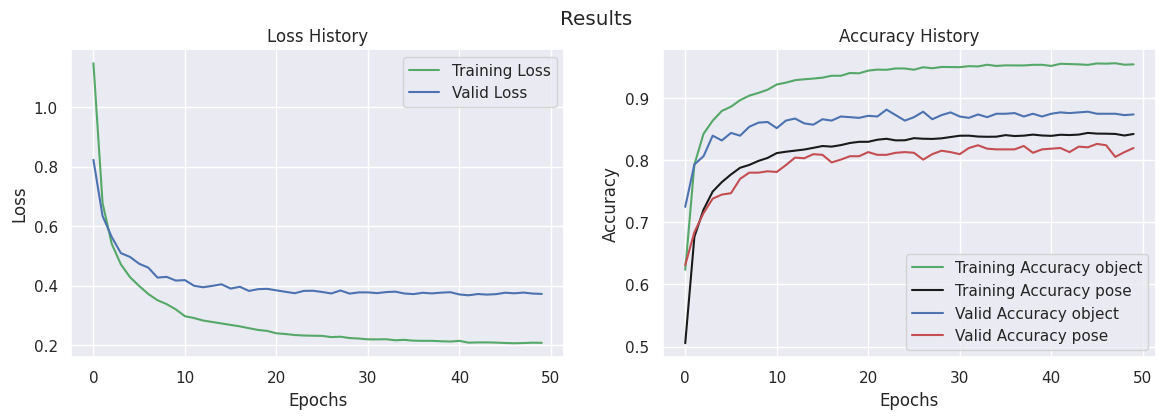

In [11]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history4 = trainer4.getHistory()
trainer4.showResults()

best model was trained at epoch: 23
with a validation loss of: 0.37414637 and a validation accuracy of: 88.10572624206543


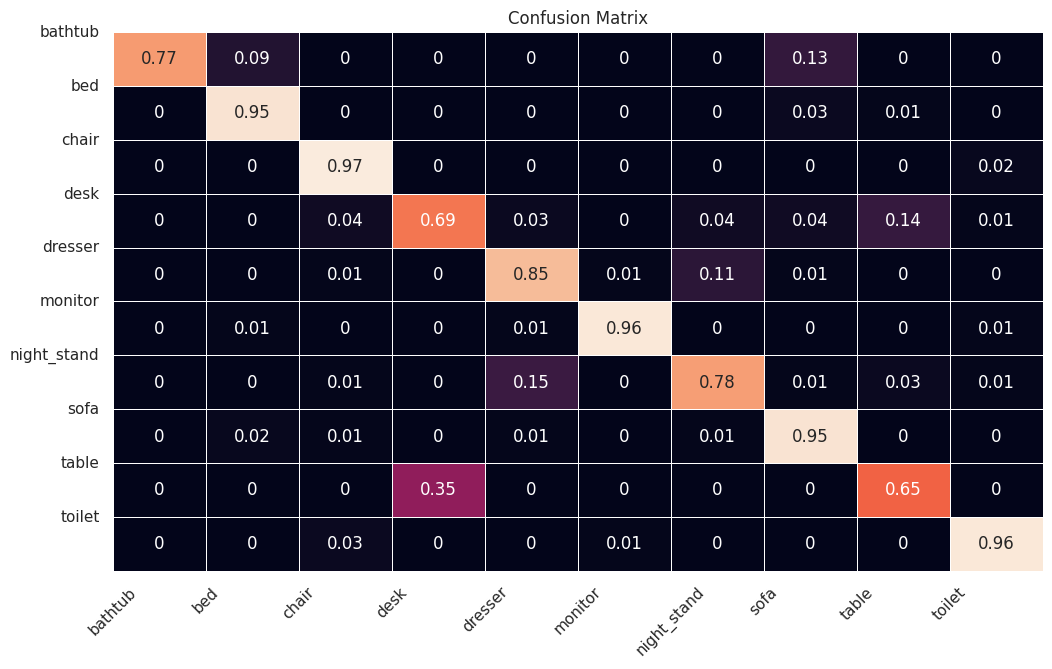

In [12]:
trainer4.generateConfusionMatrix()

best model was trained at epoch: 23
with a validation loss of: 0.37414637 and a validation accuracy of: 88.10572624206543


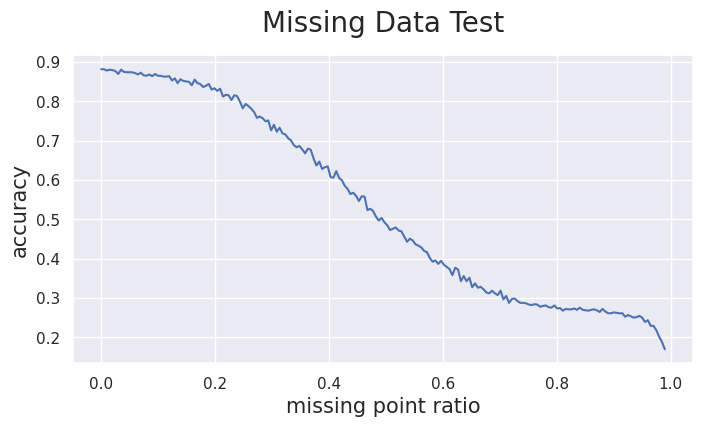

In [13]:
trainer4.missing_data_test()

In [14]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 10,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'BatchNormVoxNet_a'
}    

trainer5 = VoxNet_Trainer_a(training_hyperparameters)
trainer5.train()

model BatchNormVoxNet was chosen
499.25


Train loss: 0.7790772914886475: : 499it [02:28,  3.35it/s]
29it [00:02, 10.98it/s]


epoch:  1 / 50
time: 151.62 seconds
train-loss: 1.19, train-acc-object: 60.92%, train-acc-pose: 48.14%
valid-loss: 0.91, valid-acc-object: 69.49%, train-acc-pose: 59.36%



Train loss: 0.5977485179901123: : 499it [02:32,  3.28it/s]
29it [00:03,  7.89it/s]


epoch:  2 / 50
time: 155.75 seconds
train-loss: 0.68, train-acc-object: 79.42%, train-acc-pose: 66.25%
valid-loss: 0.64, valid-acc-object: 78.74%, train-acc-pose: 67.18%



Train loss: 0.4857804775238037: : 499it [02:37,  3.16it/s]
29it [00:03,  8.79it/s]


epoch:  3 / 50
time: 161.03 seconds
train-loss: 0.53, train-acc-object: 84.49%, train-acc-pose: 72.23%
valid-loss: 0.57, valid-acc-object: 80.29%, train-acc-pose: 71.15%



Train loss: 0.42943769693374634: : 499it [02:31,  3.29it/s]
29it [00:02, 10.84it/s]


epoch:  4 / 50
time: 154.50 seconds
train-loss: 0.46, train-acc-object: 86.80%, train-acc-pose: 74.92%
valid-loss: 0.52, valid-acc-object: 83.59%, train-acc-pose: 72.03%



Train loss: 0.46757379174232483: : 499it [02:29,  3.34it/s]
29it [00:02, 10.46it/s]


epoch:  5 / 50
time: 152.15 seconds
train-loss: 0.41, train-acc-object: 88.30%, train-acc-pose: 76.51%
valid-loss: 0.51, valid-acc-object: 83.92%, train-acc-pose: 72.58%



Train loss: 0.44177067279815674: : 499it [02:33,  3.26it/s]
29it [00:04,  7.18it/s]


epoch:  6 / 50
time: 157.06 seconds
train-loss: 0.38, train-acc-object: 89.28%, train-acc-pose: 77.46%
valid-loss: 0.48, valid-acc-object: 84.69%, train-acc-pose: 76.43%



Train loss: 0.3659629821777344: : 499it [02:29,  3.34it/s]
29it [00:02, 10.76it/s]


epoch:  7 / 50
time: 152.15 seconds
train-loss: 0.36, train-acc-object: 90.08%, train-acc-pose: 78.73%
valid-loss: 0.45, valid-acc-object: 85.68%, train-acc-pose: 75.33%



Train loss: 0.25305432081222534: : 499it [02:31,  3.29it/s]
29it [00:02, 10.39it/s]


epoch:  8 / 50
time: 154.45 seconds
train-loss: 0.33, train-acc-object: 91.03%, train-acc-pose: 79.43%
valid-loss: 0.43, valid-acc-object: 85.46%, train-acc-pose: 77.31%



Train loss: 0.18522700667381287: : 499it [02:35,  3.21it/s]
29it [00:03,  9.58it/s]


epoch:  9 / 50
time: 158.69 seconds
train-loss: 0.31, train-acc-object: 91.59%, train-acc-pose: 80.36%
valid-loss: 0.42, valid-acc-object: 87.00%, train-acc-pose: 77.42%



Train loss: 0.2740458548069: : 499it [02:34,  3.23it/s]
29it [00:02,  9.82it/s]


epoch: 10 / 50
time: 157.64 seconds
train-loss: 0.29, train-acc-object: 92.24%, train-acc-pose: 80.75%
valid-loss: 0.43, valid-acc-object: 87.56%, train-acc-pose: 78.08%



Train loss: 0.2648393511772156: : 499it [02:36,  3.18it/s]
29it [00:02, 10.03it/s]


epoch: 11 / 50
time: 159.62 seconds
train-loss: 0.28, train-acc-object: 93.01%, train-acc-pose: 81.15%
valid-loss: 0.41, valid-acc-object: 88.00%, train-acc-pose: 78.41%



Train loss: 0.31853294372558594: : 499it [02:32,  3.27it/s]
29it [00:03,  9.62it/s]


epoch: 12 / 50
time: 155.80 seconds
train-loss: 0.26, train-acc-object: 93.25%, train-acc-pose: 81.91%
valid-loss: 0.40, valid-acc-object: 87.89%, train-acc-pose: 79.30%



Train loss: 0.2755940556526184: : 499it [02:39,  3.12it/s]
29it [00:02,  9.81it/s]


epoch: 13 / 50
time: 162.79 seconds
train-loss: 0.26, train-acc-object: 93.62%, train-acc-pose: 81.92%
valid-loss: 0.40, valid-acc-object: 88.11%, train-acc-pose: 78.63%



Train loss: 0.3723350167274475: : 499it [02:38,  3.16it/s]
29it [00:03,  9.57it/s]


epoch: 14 / 50
time: 161.14 seconds
train-loss: 0.25, train-acc-object: 93.96%, train-acc-pose: 82.40%
valid-loss: 0.40, valid-acc-object: 88.00%, train-acc-pose: 78.08%



Train loss: 0.281804621219635: : 499it [02:38,  3.16it/s]
29it [00:04,  6.69it/s]


epoch: 15 / 50
time: 162.42 seconds
train-loss: 0.25, train-acc-object: 94.02%, train-acc-pose: 82.45%
valid-loss: 0.39, valid-acc-object: 88.55%, train-acc-pose: 78.63%



Train loss: 0.26494935154914856: : 499it [02:34,  3.23it/s]
29it [00:02, 10.57it/s]


epoch: 16 / 50
time: 157.29 seconds
train-loss: 0.24, train-acc-object: 94.08%, train-acc-pose: 82.34%
valid-loss: 0.38, valid-acc-object: 88.66%, train-acc-pose: 78.96%



Train loss: 0.2444636970758438: : 499it [02:30,  3.32it/s]
29it [00:03,  9.31it/s]


epoch: 17 / 50
time: 153.67 seconds
train-loss: 0.23, train-acc-object: 94.37%, train-acc-pose: 82.76%
valid-loss: 0.38, valid-acc-object: 88.33%, train-acc-pose: 78.41%



Train loss: 0.36190474033355713: : 499it [02:30,  3.31it/s]
29it [00:02,  9.88it/s]


epoch: 18 / 50
time: 153.84 seconds
train-loss: 0.23, train-acc-object: 94.51%, train-acc-pose: 82.69%
valid-loss: 0.40, valid-acc-object: 87.78%, train-acc-pose: 79.19%



Train loss: 0.2934700548648834: : 499it [02:30,  3.32it/s]
29it [00:02, 10.10it/s]


epoch: 19 / 50
time: 152.97 seconds
train-loss: 0.23, train-acc-object: 94.68%, train-acc-pose: 83.31%
valid-loss: 0.39, valid-acc-object: 88.66%, train-acc-pose: 78.85%



Train loss: 0.2075052559375763: : 499it [02:32,  3.27it/s]
29it [00:03,  7.40it/s]


epoch: 20 / 50
time: 156.46 seconds
train-loss: 0.22, train-acc-object: 94.75%, train-acc-pose: 83.39%
valid-loss: 0.39, valid-acc-object: 87.67%, train-acc-pose: 78.19%



Train loss: 0.26598885655403137: : 499it [02:30,  3.32it/s]
29it [00:02, 10.62it/s]


epoch: 21 / 50
time: 153.23 seconds
train-loss: 0.22, train-acc-object: 95.12%, train-acc-pose: 83.33%
valid-loss: 0.38, valid-acc-object: 88.77%, train-acc-pose: 79.52%



Train loss: 0.1316114217042923: : 499it [02:30,  3.31it/s]
29it [00:02, 10.68it/s]


epoch: 22 / 50
time: 153.36 seconds
train-loss: 0.21, train-acc-object: 95.36%, train-acc-pose: 83.38%
valid-loss: 0.38, valid-acc-object: 88.44%, train-acc-pose: 78.96%



Train loss: 0.14403770864009857: : 499it [02:31,  3.30it/s]
29it [00:03,  8.05it/s]


epoch: 23 / 50
time: 154.93 seconds
train-loss: 0.21, train-acc-object: 95.33%, train-acc-pose: 83.94%
valid-loss: 0.37, valid-acc-object: 88.22%, train-acc-pose: 78.74%



Train loss: 0.14099152386188507: : 499it [02:30,  3.32it/s]
29it [00:02, 10.61it/s]


epoch: 24 / 50
time: 153.06 seconds
train-loss: 0.21, train-acc-object: 95.55%, train-acc-pose: 83.82%
valid-loss: 0.37, valid-acc-object: 88.77%, train-acc-pose: 78.85%



Train loss: 0.1957804411649704: : 499it [02:31,  3.30it/s]
29it [00:03,  8.92it/s]


epoch: 25 / 50
time: 154.63 seconds
train-loss: 0.21, train-acc-object: 95.53%, train-acc-pose: 83.81%
valid-loss: 0.37, valid-acc-object: 88.55%, train-acc-pose: 79.74%



Train loss: 0.1651279777288437: : 499it [02:31,  3.29it/s]
29it [00:02, 10.65it/s]


epoch: 26 / 50
time: 154.53 seconds
train-loss: 0.20, train-acc-object: 95.57%, train-acc-pose: 83.88%
valid-loss: 0.37, valid-acc-object: 88.66%, train-acc-pose: 80.18%



Train loss: 0.1613062620162964: : 499it [02:29,  3.33it/s]
29it [00:02, 10.54it/s]


epoch: 27 / 50
time: 152.72 seconds
train-loss: 0.20, train-acc-object: 95.66%, train-acc-pose: 83.86%
valid-loss: 0.38, valid-acc-object: 88.44%, train-acc-pose: 80.62%



Train loss: 0.16860905289649963: : 499it [02:33,  3.24it/s]
29it [00:03,  9.27it/s]


epoch: 28 / 50
time: 157.06 seconds
train-loss: 0.20, train-acc-object: 95.60%, train-acc-pose: 84.06%
valid-loss: 0.37, valid-acc-object: 88.88%, train-acc-pose: 79.63%



Train loss: 0.10373465716838837: : 499it [02:33,  3.25it/s]
29it [00:02, 10.26it/s]


epoch: 29 / 50
time: 156.50 seconds
train-loss: 0.20, train-acc-object: 95.70%, train-acc-pose: 83.93%
valid-loss: 0.38, valid-acc-object: 88.77%, train-acc-pose: 80.29%



Train loss: 0.2211129367351532: : 499it [02:35,  3.22it/s]
29it [00:02, 10.14it/s]


epoch: 30 / 50
time: 158.02 seconds
train-loss: 0.20, train-acc-object: 95.86%, train-acc-pose: 84.24%
valid-loss: 0.37, valid-acc-object: 89.10%, train-acc-pose: 80.18%



Train loss: 0.1656951606273651: : 499it [02:36,  3.18it/s]
29it [00:04,  6.63it/s]


epoch: 31 / 50
time: 161.19 seconds
train-loss: 0.19, train-acc-object: 95.92%, train-acc-pose: 84.09%
valid-loss: 0.37, valid-acc-object: 88.77%, train-acc-pose: 80.95%



Train loss: 0.17928172647953033: : 499it [02:35,  3.20it/s]
29it [00:02, 10.31it/s]


epoch: 32 / 50
time: 158.80 seconds
train-loss: 0.19, train-acc-object: 95.90%, train-acc-pose: 84.45%
valid-loss: 0.38, valid-acc-object: 89.10%, train-acc-pose: 80.73%



Train loss: 0.10962748527526855: : 499it [02:32,  3.27it/s]
29it [00:03,  9.48it/s]


epoch: 33 / 50
time: 155.70 seconds
train-loss: 0.19, train-acc-object: 96.02%, train-acc-pose: 84.35%
valid-loss: 0.37, valid-acc-object: 88.88%, train-acc-pose: 80.73%



Train loss: 0.15283438563346863: : 499it [02:31,  3.29it/s]
29it [00:02, 10.44it/s]


epoch: 34 / 50
time: 154.33 seconds
train-loss: 0.19, train-acc-object: 95.94%, train-acc-pose: 84.51%
valid-loss: 0.37, valid-acc-object: 89.43%, train-acc-pose: 80.18%



Train loss: 0.13595589995384216: : 499it [02:35,  3.20it/s]
29it [00:02, 10.55it/s]


epoch: 35 / 50
time: 158.75 seconds
train-loss: 0.19, train-acc-object: 96.14%, train-acc-pose: 84.26%
valid-loss: 0.37, valid-acc-object: 89.43%, train-acc-pose: 80.62%



Train loss: 0.15080606937408447: : 499it [02:30,  3.31it/s]
29it [00:02, 10.50it/s]


epoch: 36 / 50
time: 153.71 seconds
train-loss: 0.19, train-acc-object: 96.14%, train-acc-pose: 84.57%
valid-loss: 0.37, valid-acc-object: 89.43%, train-acc-pose: 80.29%



Train loss: 0.2025374472141266: : 499it [02:31,  3.28it/s]
29it [00:03,  7.97it/s]


epoch: 37 / 50
time: 155.61 seconds
train-loss: 0.19, train-acc-object: 95.99%, train-acc-pose: 84.40%
valid-loss: 0.37, valid-acc-object: 89.43%, train-acc-pose: 79.85%



Train loss: 0.2836061120033264: : 499it [02:32,  3.27it/s]
29it [00:02, 10.20it/s]


epoch: 38 / 50
time: 155.41 seconds
train-loss: 0.19, train-acc-object: 96.20%, train-acc-pose: 84.53%
valid-loss: 0.37, valid-acc-object: 89.21%, train-acc-pose: 79.85%



Train loss: 0.19959187507629395: : 499it [02:32,  3.28it/s]
29it [00:03,  7.44it/s]


epoch: 39 / 50
time: 156.07 seconds
train-loss: 0.19, train-acc-object: 96.17%, train-acc-pose: 84.58%
valid-loss: 0.37, valid-acc-object: 88.88%, train-acc-pose: 79.63%



Train loss: 0.17926213145256042: : 499it [02:34,  3.22it/s]
29it [00:03,  9.30it/s]


epoch: 40 / 50
time: 158.06 seconds
train-loss: 0.19, train-acc-object: 96.22%, train-acc-pose: 84.66%
valid-loss: 0.37, valid-acc-object: 89.54%, train-acc-pose: 79.85%



Train loss: 0.17946124076843262: : 499it [02:42,  3.07it/s]
29it [00:03,  9.24it/s]


epoch: 41 / 50
time: 165.61 seconds
train-loss: 0.18, train-acc-object: 96.23%, train-acc-pose: 84.73%
valid-loss: 0.37, valid-acc-object: 89.43%, train-acc-pose: 80.07%



Train loss: 0.16138741374015808: : 499it [02:42,  3.08it/s]
29it [00:03,  9.54it/s]


epoch: 42 / 50
time: 165.20 seconds
train-loss: 0.18, train-acc-object: 96.34%, train-acc-pose: 84.60%
valid-loss: 0.37, valid-acc-object: 89.43%, train-acc-pose: 80.29%



Train loss: 0.14935213327407837: : 499it [02:40,  3.11it/s]
29it [00:03,  9.24it/s]


epoch: 43 / 50
time: 163.80 seconds
train-loss: 0.18, train-acc-object: 96.27%, train-acc-pose: 84.59%
valid-loss: 0.37, valid-acc-object: 89.43%, train-acc-pose: 80.73%



Train loss: 0.23909735679626465: : 499it [02:39,  3.14it/s]
29it [00:02,  9.94it/s]


epoch: 44 / 50
time: 162.04 seconds
train-loss: 0.19, train-acc-object: 96.20%, train-acc-pose: 84.48%
valid-loss: 0.37, valid-acc-object: 89.54%, train-acc-pose: 80.51%



Train loss: 0.17386819422245026: : 499it [02:36,  3.19it/s]
29it [00:03,  7.64it/s]


epoch: 45 / 50
time: 160.25 seconds
train-loss: 0.18, train-acc-object: 96.45%, train-acc-pose: 84.86%
valid-loss: 0.37, valid-acc-object: 89.21%, train-acc-pose: 80.07%



Train loss: 0.1588280200958252: : 499it [02:36,  3.18it/s]
29it [00:03,  8.20it/s]


epoch: 46 / 50
time: 160.33 seconds
train-loss: 0.18, train-acc-object: 96.38%, train-acc-pose: 84.83%
valid-loss: 0.37, valid-acc-object: 89.32%, train-acc-pose: 79.85%



Train loss: 0.16487306356430054: : 499it [02:35,  3.22it/s]
29it [00:03,  9.35it/s]


epoch: 47 / 50
time: 158.22 seconds
train-loss: 0.18, train-acc-object: 96.38%, train-acc-pose: 84.59%
valid-loss: 0.37, valid-acc-object: 89.43%, train-acc-pose: 80.40%



Train loss: 0.16275286674499512: : 499it [02:39,  3.14it/s]
29it [00:02,  9.85it/s]


epoch: 48 / 50
time: 162.03 seconds
train-loss: 0.18, train-acc-object: 96.34%, train-acc-pose: 84.97%
valid-loss: 0.37, valid-acc-object: 89.43%, train-acc-pose: 80.29%



Train loss: 0.199060320854187: : 499it [02:33,  3.25it/s]
29it [00:04,  6.94it/s]


epoch: 49 / 50
time: 157.66 seconds
train-loss: 0.18, train-acc-object: 96.47%, train-acc-pose: 84.96%
valid-loss: 0.37, valid-acc-object: 89.43%, train-acc-pose: 80.40%



Train loss: 0.15887658298015594: : 499it [02:34,  3.23it/s]
29it [00:02, 10.46it/s]

epoch: 50 / 50
time: 157.19 seconds
train-loss: 0.18, train-acc-object: 96.24%, train-acc-pose: 84.51%
valid-loss: 0.37, valid-acc-object: 89.54%, train-acc-pose: 80.18%



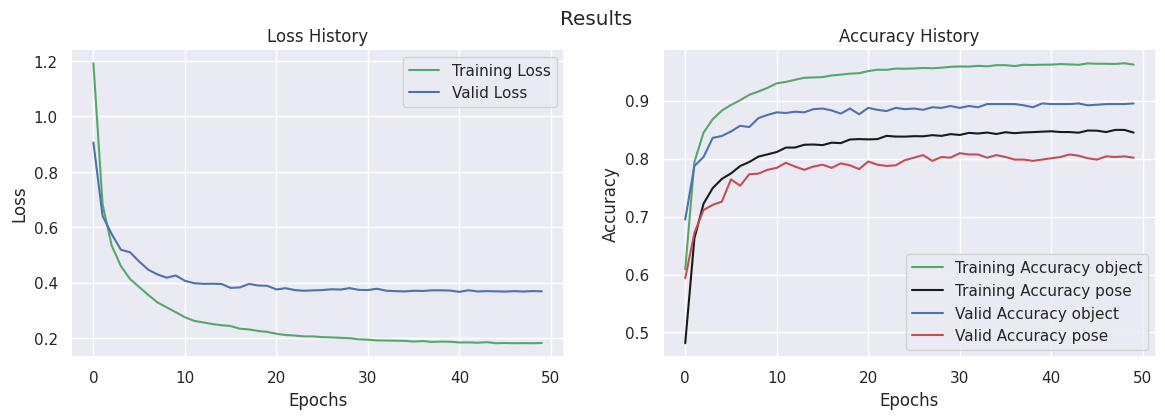

In [15]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history5 = trainer5.getHistory()
trainer5.showResults()

best model was trained at epoch: 40
with a validation loss of: 0.37117702 and a validation accuracy of: 89.53744769096375


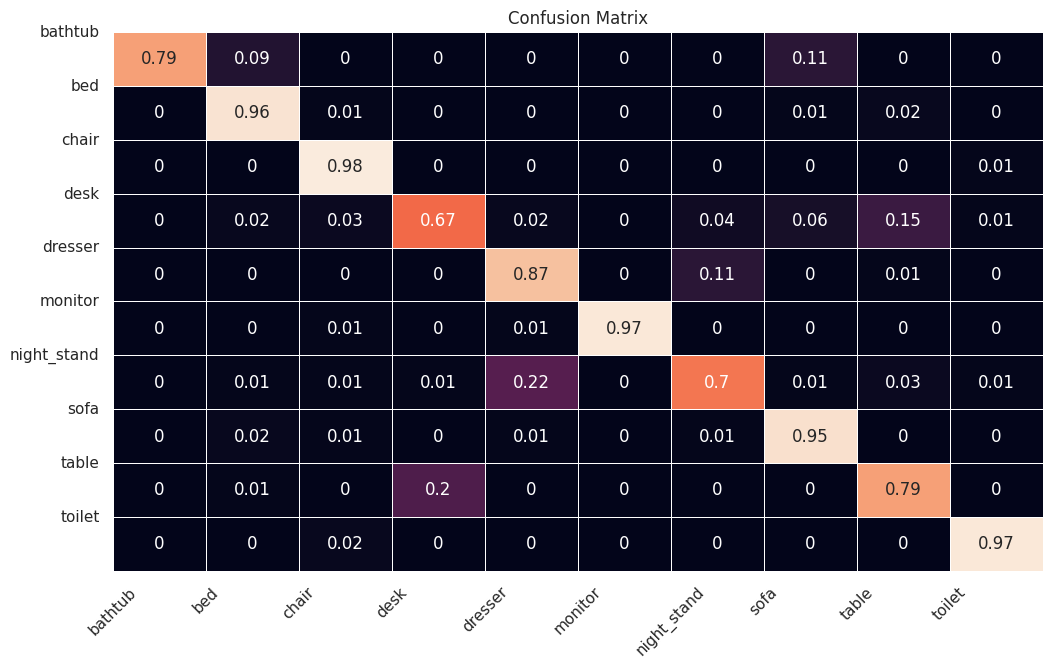

In [16]:
trainer5.generateConfusionMatrix()

best model was trained at epoch: 40
with a validation loss of: 0.37117702 and a validation accuracy of: 89.53744769096375


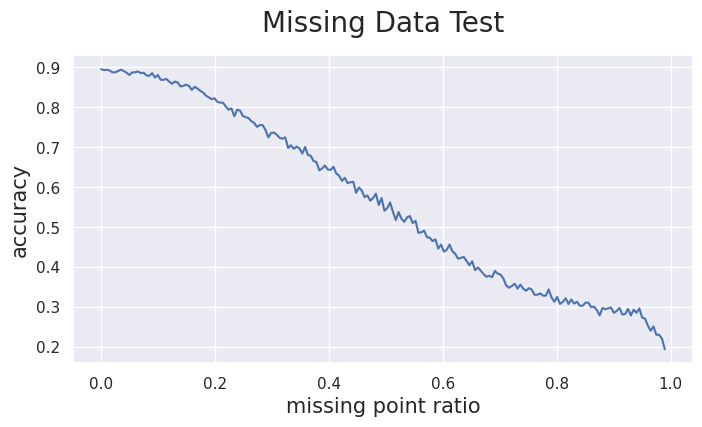

In [17]:
trainer5.missing_data_test()

In [20]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 10,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'DMPVoxNet_a'
}    

trainer6 = VoxNet_Trainer_a(training_hyperparameters)
trainer6.train()

model DMPVoxNet was choosen
499.25


Train loss: 0.5996252298355103: : 499it [03:55,  2.12it/s]
29it [00:03,  8.72it/s]


epoch:  1 / 50
time: 238.64 seconds
train-loss: 1.09, train-acc-object: 64.65%, train-acc-pose: 51.68%
valid-loss: 1.04, valid-acc-object: 74.56%, train-acc-pose: 65.09%



Train loss: 0.5087482929229736: : 499it [03:52,  2.14it/s]
29it [00:04,  6.49it/s]


epoch:  2 / 50
time: 237.34 seconds
train-loss: 0.58, train-acc-object: 81.93%, train-acc-pose: 71.37%
valid-loss: 0.83, valid-acc-object: 79.85%, train-acc-pose: 70.04%



Train loss: 0.3775501251220703: : 499it [03:48,  2.18it/s]
29it [00:03,  9.32it/s]


epoch:  3 / 50
time: 231.97 seconds
train-loss: 0.45, train-acc-object: 86.79%, train-acc-pose: 75.35%
valid-loss: 0.69, valid-acc-object: 82.49%, train-acc-pose: 75.77%



Train loss: 0.32418033480644226: : 499it [03:46,  2.20it/s]
29it [00:03,  9.22it/s]


epoch:  4 / 50
time: 230.11 seconds
train-loss: 0.39, train-acc-object: 88.86%, train-acc-pose: 77.64%
valid-loss: 0.63, valid-acc-object: 83.81%, train-acc-pose: 73.35%



Train loss: 0.24482941627502441: : 499it [03:51,  2.15it/s]
29it [00:03,  8.62it/s]


epoch:  5 / 50
time: 235.37 seconds
train-loss: 0.34, train-acc-object: 90.28%, train-acc-pose: 78.93%
valid-loss: 0.61, valid-acc-object: 84.91%, train-acc-pose: 74.45%



Train loss: 0.3325294256210327: : 499it [03:50,  2.17it/s]
29it [00:04,  6.80it/s]


epoch:  6 / 50
time: 234.33 seconds
train-loss: 0.32, train-acc-object: 91.21%, train-acc-pose: 79.56%
valid-loss: 0.56, valid-acc-object: 84.80%, train-acc-pose: 76.21%



Train loss: 0.2915167212486267: : 499it [03:44,  2.22it/s]
29it [00:03,  8.03it/s]


epoch:  7 / 50
time: 228.07 seconds
train-loss: 0.29, train-acc-object: 92.15%, train-acc-pose: 80.29%
valid-loss: 0.52, valid-acc-object: 84.80%, train-acc-pose: 76.87%



Train loss: 0.38176822662353516: : 499it [03:46,  2.20it/s]
29it [00:03,  9.24it/s]


epoch:  8 / 50
time: 229.93 seconds
train-loss: 0.28, train-acc-object: 92.81%, train-acc-pose: 81.01%
valid-loss: 0.50, valid-acc-object: 87.56%, train-acc-pose: 77.97%



Train loss: 0.2754255533218384: : 499it [03:44,  2.22it/s]
29it [00:03,  9.51it/s]


epoch:  9 / 50
time: 227.64 seconds
train-loss: 0.26, train-acc-object: 93.36%, train-acc-pose: 81.55%
valid-loss: 0.48, valid-acc-object: 87.56%, train-acc-pose: 78.63%



Train loss: 0.17305749654769897: : 499it [03:44,  2.22it/s]
29it [00:03,  9.10it/s]


epoch: 10 / 50
time: 227.95 seconds
train-loss: 0.25, train-acc-object: 93.83%, train-acc-pose: 81.88%
valid-loss: 0.48, valid-acc-object: 85.35%, train-acc-pose: 77.97%



Train loss: 0.14527280628681183: : 499it [03:43,  2.23it/s]
29it [00:03,  9.58it/s]


epoch: 11 / 50
time: 226.62 seconds
train-loss: 0.22, train-acc-object: 94.95%, train-acc-pose: 82.69%
valid-loss: 0.43, valid-acc-object: 89.32%, train-acc-pose: 78.52%



Train loss: 0.23381860554218292: : 499it [03:43,  2.23it/s]
29it [00:03,  9.44it/s]


epoch: 12 / 50
time: 226.96 seconds
train-loss: 0.21, train-acc-object: 95.24%, train-acc-pose: 82.87%
valid-loss: 0.43, valid-acc-object: 88.55%, train-acc-pose: 80.62%



Train loss: 0.16143392026424408: : 499it [03:43,  2.23it/s]
29it [00:02,  9.70it/s]


epoch: 13 / 50
time: 226.81 seconds
train-loss: 0.21, train-acc-object: 95.45%, train-acc-pose: 83.03%
valid-loss: 0.42, valid-acc-object: 89.87%, train-acc-pose: 78.85%



Train loss: 0.20585907995700836: : 499it [03:42,  2.24it/s]
29it [00:03,  8.85it/s]


epoch: 14 / 50
time: 225.79 seconds
train-loss: 0.20, train-acc-object: 95.51%, train-acc-pose: 83.25%
valid-loss: 0.43, valid-acc-object: 87.67%, train-acc-pose: 80.73%



Train loss: 0.15546360611915588: : 499it [03:42,  2.24it/s]
29it [00:03,  7.88it/s]


epoch: 15 / 50
time: 226.21 seconds
train-loss: 0.20, train-acc-object: 95.85%, train-acc-pose: 83.53%
valid-loss: 0.40, valid-acc-object: 88.88%, train-acc-pose: 78.85%



Train loss: 0.22542816400527954: : 499it [03:42,  2.24it/s]
29it [00:04,  7.01it/s]


epoch: 16 / 50
time: 227.06 seconds
train-loss: 0.19, train-acc-object: 95.93%, train-acc-pose: 83.63%
valid-loss: 0.40, valid-acc-object: 88.66%, train-acc-pose: 80.18%



Train loss: 0.24099858105182648: : 499it [03:44,  2.22it/s]
29it [00:03,  9.13it/s]


epoch: 17 / 50
time: 227.61 seconds
train-loss: 0.19, train-acc-object: 96.11%, train-acc-pose: 83.50%
valid-loss: 0.39, valid-acc-object: 89.76%, train-acc-pose: 80.29%



Train loss: 0.19525650143623352: : 499it [03:43,  2.23it/s]
29it [00:03,  9.18it/s]


epoch: 18 / 50
time: 227.08 seconds
train-loss: 0.19, train-acc-object: 96.26%, train-acc-pose: 83.76%
valid-loss: 0.39, valid-acc-object: 89.76%, train-acc-pose: 80.40%



Train loss: 0.13453763723373413: : 499it [03:43,  2.23it/s]
29it [00:03,  9.32it/s]


epoch: 19 / 50
time: 226.96 seconds
train-loss: 0.18, train-acc-object: 96.26%, train-acc-pose: 84.08%
valid-loss: 0.40, valid-acc-object: 87.44%, train-acc-pose: 82.16%



Train loss: 0.13591879606246948: : 499it [03:45,  2.21it/s]
29it [00:03,  9.26it/s]


epoch: 20 / 50
time: 228.95 seconds
train-loss: 0.18, train-acc-object: 96.36%, train-acc-pose: 84.06%
valid-loss: 0.39, valid-acc-object: 89.43%, train-acc-pose: 80.18%



Train loss: 0.24740859866142273: : 499it [03:43,  2.23it/s]
29it [00:03,  9.44it/s]


epoch: 21 / 50
time: 226.58 seconds
train-loss: 0.17, train-acc-object: 96.67%, train-acc-pose: 84.33%
valid-loss: 0.38, valid-acc-object: 88.77%, train-acc-pose: 80.84%



Train loss: 0.18385270237922668: : 499it [03:44,  2.22it/s]
29it [00:04,  6.87it/s]


epoch: 22 / 50
time: 229.04 seconds
train-loss: 0.17, train-acc-object: 97.03%, train-acc-pose: 84.71%
valid-loss: 0.37, valid-acc-object: 89.87%, train-acc-pose: 80.62%



Train loss: 0.19674481451511383: : 499it [03:45,  2.21it/s]
29it [00:03,  9.16it/s]


epoch: 23 / 50
time: 228.92 seconds
train-loss: 0.16, train-acc-object: 97.00%, train-acc-pose: 84.72%
valid-loss: 0.37, valid-acc-object: 89.32%, train-acc-pose: 80.73%



Train loss: 0.1642816960811615: : 499it [03:45,  2.21it/s]
29it [00:03,  9.60it/s]


epoch: 24 / 50
time: 228.65 seconds
train-loss: 0.16, train-acc-object: 97.10%, train-acc-pose: 84.81%
valid-loss: 0.37, valid-acc-object: 89.32%, train-acc-pose: 81.28%



Train loss: 0.13843396306037903: : 499it [03:44,  2.23it/s]
29it [00:03,  9.43it/s]


epoch: 25 / 50
time: 227.34 seconds
train-loss: 0.16, train-acc-object: 97.20%, train-acc-pose: 84.74%
valid-loss: 0.37, valid-acc-object: 88.99%, train-acc-pose: 81.17%



Train loss: 0.17825911939144135: : 499it [03:44,  2.22it/s]
29it [00:03,  8.51it/s]


epoch: 26 / 50
time: 227.84 seconds
train-loss: 0.16, train-acc-object: 97.09%, train-acc-pose: 84.64%
valid-loss: 0.36, valid-acc-object: 89.32%, train-acc-pose: 81.61%



Train loss: 0.13202853500843048: : 499it [03:45,  2.22it/s]
29it [00:03,  7.57it/s]


epoch: 27 / 50
time: 229.07 seconds
train-loss: 0.16, train-acc-object: 97.24%, train-acc-pose: 84.81%
valid-loss: 0.36, valid-acc-object: 90.42%, train-acc-pose: 80.62%



Train loss: 0.15402090549468994: : 499it [03:44,  2.22it/s]
29it [00:03,  9.48it/s]


epoch: 28 / 50
time: 227.59 seconds
train-loss: 0.16, train-acc-object: 97.21%, train-acc-pose: 85.31%
valid-loss: 0.36, valid-acc-object: 89.87%, train-acc-pose: 81.83%



Train loss: 0.17868027091026306: : 499it [03:43,  2.23it/s]
29it [00:03,  9.41it/s]


epoch: 29 / 50
time: 226.52 seconds
train-loss: 0.16, train-acc-object: 97.35%, train-acc-pose: 85.05%
valid-loss: 0.36, valid-acc-object: 90.09%, train-acc-pose: 81.50%



Train loss: 0.12624166905879974: : 499it [03:43,  2.23it/s]
29it [00:02,  9.78it/s]


epoch: 30 / 50
time: 226.75 seconds
train-loss: 0.15, train-acc-object: 97.40%, train-acc-pose: 85.05%
valid-loss: 0.35, valid-acc-object: 89.10%, train-acc-pose: 81.39%



Train loss: 0.11831780523061752: : 499it [03:43,  2.23it/s]
29it [00:03,  8.49it/s]


epoch: 31 / 50
time: 226.76 seconds
train-loss: 0.15, train-acc-object: 97.64%, train-acc-pose: 85.30%
valid-loss: 0.36, valid-acc-object: 89.21%, train-acc-pose: 81.61%



Train loss: 0.17503982782363892: : 499it [03:44,  2.23it/s]
29it [00:04,  7.04it/s]


epoch: 32 / 50
time: 228.40 seconds
train-loss: 0.15, train-acc-object: 97.55%, train-acc-pose: 85.05%
valid-loss: 0.35, valid-acc-object: 89.98%, train-acc-pose: 82.05%



Train loss: 0.07497777789831161: : 499it [03:44,  2.23it/s]
29it [00:03,  9.60it/s]


epoch: 33 / 50
time: 227.23 seconds
train-loss: 0.15, train-acc-object: 97.56%, train-acc-pose: 85.73%
valid-loss: 0.35, valid-acc-object: 89.54%, train-acc-pose: 81.61%



Train loss: 0.09919685125350952: : 499it [03:42,  2.24it/s]
29it [00:03,  9.46it/s]


epoch: 34 / 50
time: 226.07 seconds
train-loss: 0.15, train-acc-object: 97.69%, train-acc-pose: 85.41%
valid-loss: 0.35, valid-acc-object: 89.76%, train-acc-pose: 81.94%



Train loss: 0.17216506600379944: : 499it [03:42,  2.24it/s]
29it [00:02,  9.68it/s]


epoch: 35 / 50
time: 225.47 seconds
train-loss: 0.14, train-acc-object: 97.71%, train-acc-pose: 85.50%
valid-loss: 0.35, valid-acc-object: 89.10%, train-acc-pose: 82.05%



Train loss: 0.10033145546913147: : 499it [03:44,  2.23it/s]
29it [00:03,  9.31it/s]


epoch: 36 / 50
time: 227.28 seconds
train-loss: 0.14, train-acc-object: 97.74%, train-acc-pose: 85.45%
valid-loss: 0.35, valid-acc-object: 89.21%, train-acc-pose: 81.28%



Train loss: 0.2156667709350586: : 499it [03:44,  2.22it/s]
29it [00:04,  7.11it/s]


epoch: 37 / 50
time: 228.39 seconds
train-loss: 0.14, train-acc-object: 97.79%, train-acc-pose: 85.51%
valid-loss: 0.35, valid-acc-object: 89.65%, train-acc-pose: 81.83%



Train loss: 0.1512434482574463: : 499it [03:45,  2.22it/s]
29it [00:03,  8.73it/s]


epoch: 38 / 50
time: 228.36 seconds
train-loss: 0.14, train-acc-object: 97.82%, train-acc-pose: 85.45%
valid-loss: 0.35, valid-acc-object: 89.54%, train-acc-pose: 82.05%



Train loss: 0.12082527577877045: : 499it [03:46,  2.21it/s]
29it [00:03,  8.70it/s]


epoch: 39 / 50
time: 229.42 seconds
train-loss: 0.14, train-acc-object: 97.65%, train-acc-pose: 85.50%
valid-loss: 0.35, valid-acc-object: 89.43%, train-acc-pose: 81.83%



Train loss: 0.1533564031124115: : 499it [03:46,  2.20it/s]
29it [00:03,  8.85it/s]


epoch: 40 / 50
time: 230.06 seconds
train-loss: 0.14, train-acc-object: 97.83%, train-acc-pose: 85.61%
valid-loss: 0.35, valid-acc-object: 89.65%, train-acc-pose: 82.05%



Train loss: 0.11098036915063858: : 499it [03:47,  2.19it/s]
29it [00:03,  8.73it/s]


epoch: 41 / 50
time: 230.80 seconds
train-loss: 0.14, train-acc-object: 97.99%, train-acc-pose: 85.74%
valid-loss: 0.34, valid-acc-object: 89.65%, train-acc-pose: 82.05%



Train loss: 0.1465940773487091: : 499it [03:44,  2.22it/s]
29it [00:03,  7.42it/s]


epoch: 42 / 50
time: 228.40 seconds
train-loss: 0.14, train-acc-object: 98.00%, train-acc-pose: 85.75%
valid-loss: 0.34, valid-acc-object: 89.87%, train-acc-pose: 82.49%



Train loss: 0.12517604231834412: : 499it [03:44,  2.22it/s]
29it [00:03,  9.15it/s]


epoch: 43 / 50
time: 227.67 seconds
train-loss: 0.14, train-acc-object: 97.92%, train-acc-pose: 85.60%
valid-loss: 0.34, valid-acc-object: 89.76%, train-acc-pose: 82.49%



Train loss: 0.1578451544046402: : 499it [03:44,  2.22it/s]
29it [00:03,  9.57it/s]


epoch: 44 / 50
time: 227.49 seconds
train-loss: 0.14, train-acc-object: 97.94%, train-acc-pose: 85.67%
valid-loss: 0.35, valid-acc-object: 89.54%, train-acc-pose: 82.27%



Train loss: 0.10328169167041779: : 499it [03:43,  2.23it/s]
29it [00:03,  7.87it/s]


epoch: 45 / 50
time: 227.20 seconds
train-loss: 0.14, train-acc-object: 97.78%, train-acc-pose: 85.85%
valid-loss: 0.34, valid-acc-object: 89.87%, train-acc-pose: 82.16%



Train loss: 0.16478870809078217: : 499it [03:43,  2.24it/s]
29it [00:03,  7.87it/s]


epoch: 46 / 50
time: 226.81 seconds
train-loss: 0.14, train-acc-object: 97.99%, train-acc-pose: 85.65%
valid-loss: 0.34, valid-acc-object: 89.87%, train-acc-pose: 82.38%



Train loss: 0.09676304459571838: : 499it [03:44,  2.22it/s]
29it [00:03,  9.11it/s]


epoch: 47 / 50
time: 227.81 seconds
train-loss: 0.14, train-acc-object: 97.97%, train-acc-pose: 85.58%
valid-loss: 0.34, valid-acc-object: 89.32%, train-acc-pose: 82.38%



Train loss: 0.09690099954605103: : 499it [03:44,  2.22it/s]
29it [00:03,  9.46it/s]


epoch: 48 / 50
time: 227.73 seconds
train-loss: 0.14, train-acc-object: 97.93%, train-acc-pose: 85.82%
valid-loss: 0.34, valid-acc-object: 89.54%, train-acc-pose: 82.16%



Train loss: 0.09274140745401382: : 499it [03:44,  2.23it/s]
29it [00:04,  6.96it/s]


epoch: 49 / 50
time: 228.27 seconds
train-loss: 0.14, train-acc-object: 98.03%, train-acc-pose: 85.77%
valid-loss: 0.34, valid-acc-object: 89.54%, train-acc-pose: 81.72%



Train loss: 0.13179194927215576: : 499it [03:44,  2.22it/s]
29it [00:03,  9.01it/s]

epoch: 50 / 50
time: 228.14 seconds
train-loss: 0.14, train-acc-object: 98.06%, train-acc-pose: 85.74%
valid-loss: 0.34, valid-acc-object: 90.09%, train-acc-pose: 82.38%



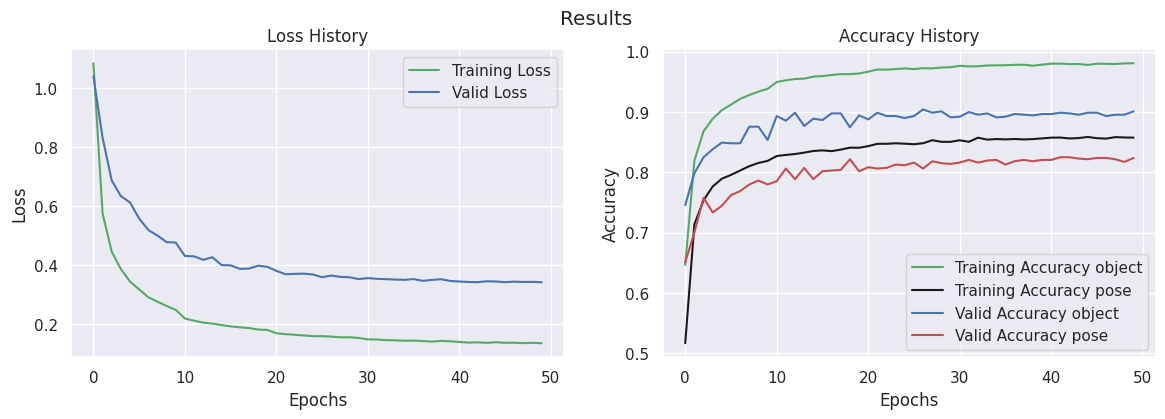

In [21]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history6 = trainer6.getHistory()
trainer6.showResults()

best model was trained at epoch: 27
with a validation loss of: 0.3648917 and a validation accuracy of: 90.41849970817566


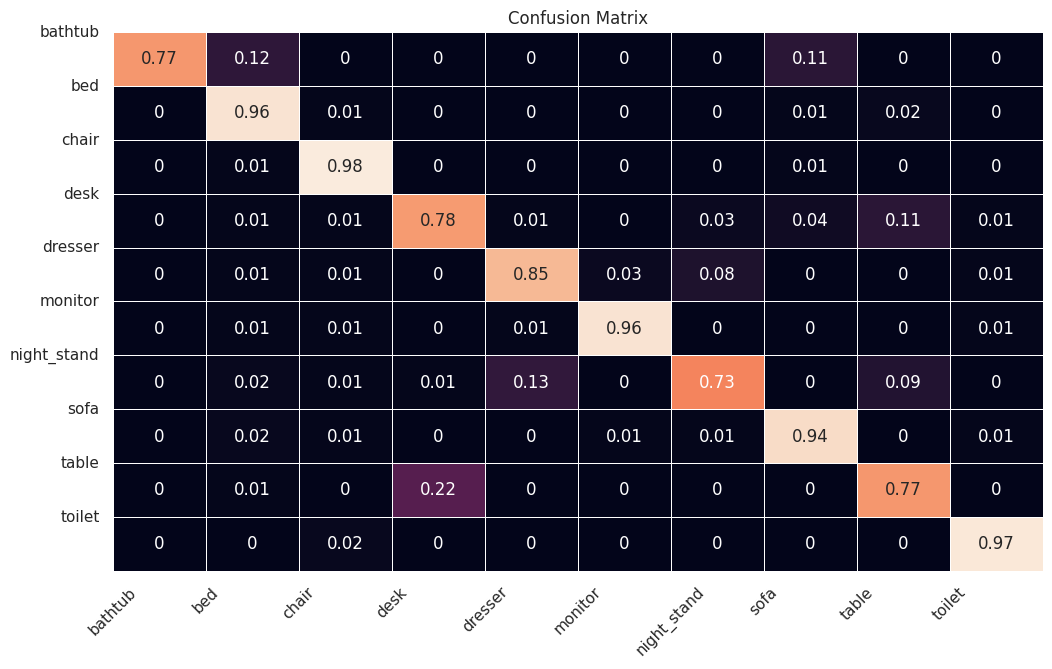

In [22]:
trainer6.generateConfusionMatrix()

best model was trained at epoch: 27
with a validation loss of: 0.3648917 and a validation accuracy of: 90.41849970817566


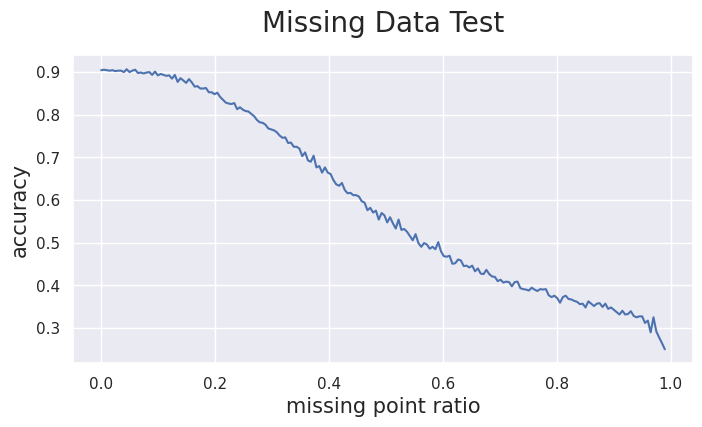

In [23]:
trainer6.missing_data_test()

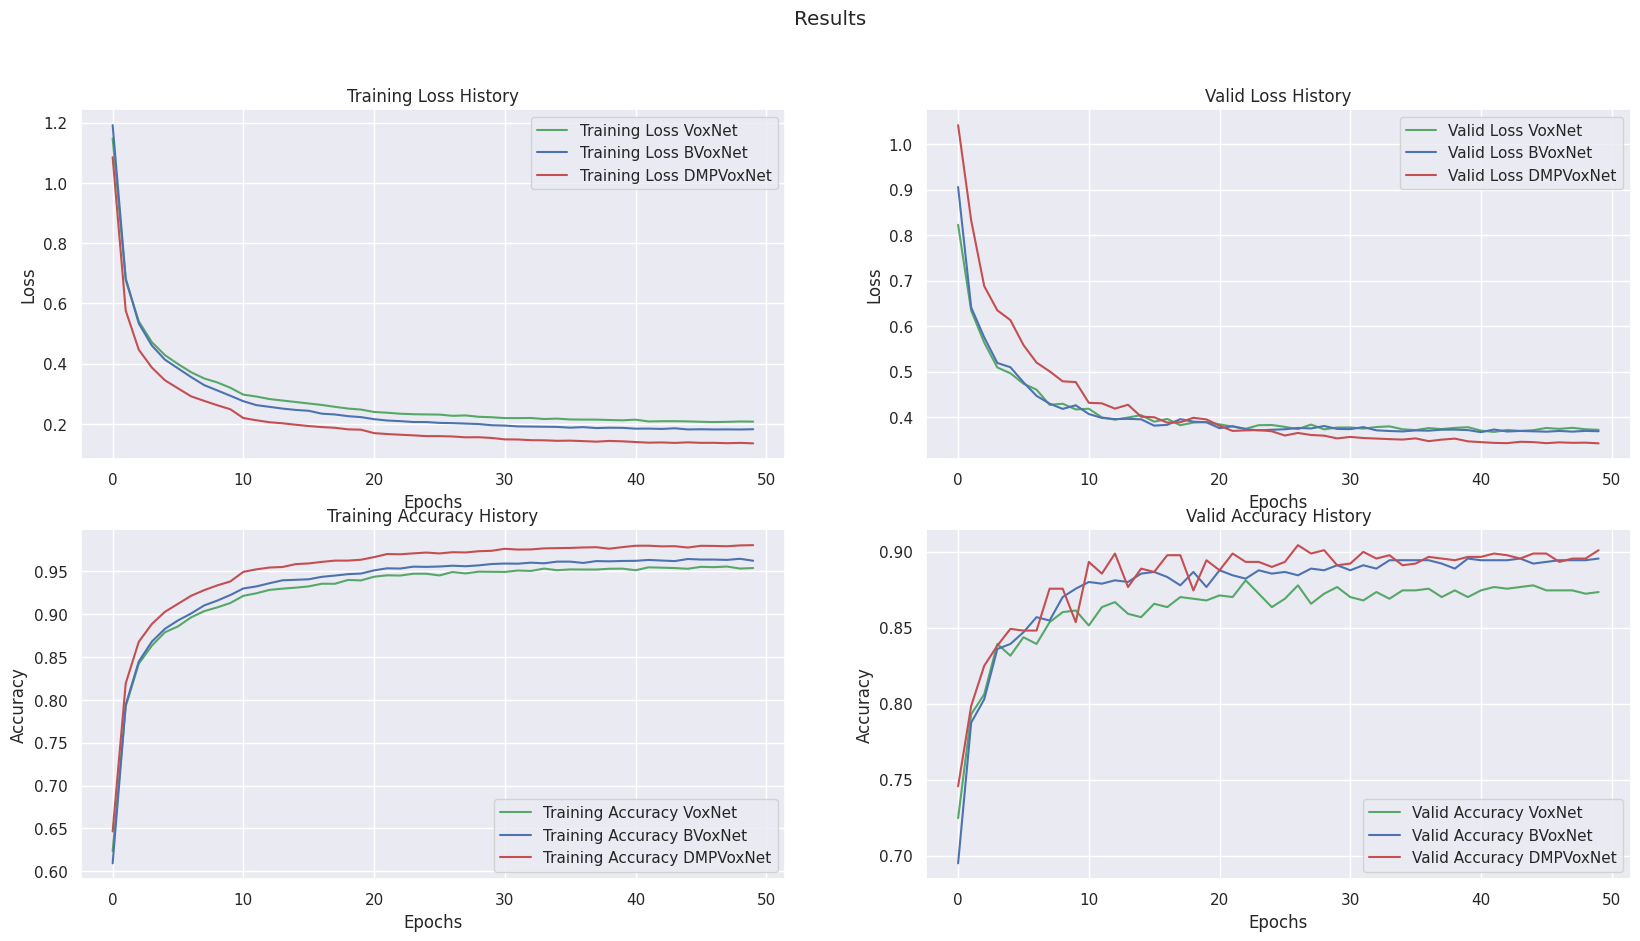

In [24]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

eps = range(0, len(history4["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')
        
ax[0,0].plot(eps, smooth(history4["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0,0].plot(eps, smooth(history5["train_loss"].cpu()), 'b', label='Training Loss BVoxNet')
ax[0,0].plot(eps, smooth(history6["train_loss"].cpu()), 'r', label='Training Loss DMPVoxNet')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()
        
ax[0,1].plot(eps, smooth(history4["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet')
ax[0,1].plot(eps, smooth(history5["valid_loss"].cpu()), 'b', label='Valid Loss BVoxNet')
ax[0,1].plot(eps, smooth(history6["valid_loss"].cpu()), 'r', label='Valid Loss DMPVoxNet')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history4["train_acc1"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[1,0].plot(eps, smooth(history5["train_acc1"].cpu()), 'b', label='Training Accuracy BVoxNet')
ax[1,0].plot(eps, smooth(history6["train_acc1"].cpu()), 'r', label='Training Accuracy DMPVoxNet')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history4["valid_acc1"].cpu()), 'g', label='Valid Accuracy VoxNet')
ax[1,1].plot(eps, smooth(history5["valid_acc1"].cpu()), 'b', label='Valid Accuracy BVoxNet')
ax[1,1].plot(eps, smooth(history6["valid_acc1"].cpu()), 'r', label='Valid Accuracy DMPVoxNet')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()

# PointNet

In [ ]:
import os
import random
import math

!pip install path.py;
from path import Path

path = Path("ModelNet10")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]], verts[faces[i][1]], verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, weights=areas, cum_weights=None, k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]], verts[sampled_faces[i][1]], verts[sampled_faces[i][2]]))
        
        return sampled_points


class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [ ]:
def default_transforms():
    return transforms.Compose([PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}

In [ ]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [ ]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [ ]:
class PointNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.num_classes = len(self.class_names)

      #Model
      self.initModel(hyperparameters)
  
  def initDataset(self):
      self.train_ds = PointCloudData(path, transform=train_transforms)
      self.test_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self, hyperparameters):
      self.model = PointNet()
      print("model PointNet was chosen")
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history, valid_acc_history = [], []
      train_accuracy = Accuracy(task='multiclass', num_classes=10)
      valid_accuracy = Accuracy(task='multiclass', num_classes=10)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels = data['pointcloud'].to(self.device).float(), data['category'].to(self.device)

              self.opt.zero_grad()
              outputs, m3x3, m64x64 = self.model(inputs.transpose(1,2))  # torch.Size([256, 10])
              loss = pointnetloss(outputs, labels, m3x3, m64x64)
              train_loss.append(loss.cpu().data)
              train_accuracy.update(torch.argmax(outputs, 1).cpu(), labels.cpu()) 

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
                      
          with torch.no_grad():
            self.model.eval()
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test = sample['pointcloud'].to(self.device).float(), sample['category'].to(self.device)
                
                outputs_test, m3x3, m64x64  = self.model(inputs_test.transpose(1,2))
                loss_test = pointnetloss(outputs_test, labels_test, m3x3, m64x64)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy.update(torch.argmax(outputs_test, 1).cpu(), labels_test.cpu())
                pred_choice_test = outputs_test.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(outputs_test, 1))
                self.y_conf.append(labels_test)

          #compute confusion matrix
          a = torch.cat(self.pred_conf).cpu()
          b = torch.cat(self.y_conf).cpu()
          confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
          self.conf_matrix = confmat(a, b)
          self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

          # total accuracy over all batches
          total_train_accuracy = train_accuracy.compute()
          total_valid_accuracy = valid_accuracy.compute()
          train_accuracy.reset()
          valid_accuracy.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history.append(total_train_accuracy)
          valid_acc_history.append(total_valid_accuracy)
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")
          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc"].cpu()), 'g', label='Training Accuracy')
      ax[1].plot(eps, smooth(self.history["valid_acc"].cpu()), 'b', label='Valid Accuracy')
      ax[1].set_title('Loss History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)
        
      self.model.eval()
      for x, y in self.test_dataloader:
          x, y = x.to(self.device), y.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)
      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "data_size": 32,
    "epochs": 20,
    "train_batch_size": 32,
    "valid_batch_size": 64,
}    

trainer7 = PointNet_Trainer(training_hyperparameters)
trainer7.train()

NameError: ignored

# Download and unzip the dataset ModelNet40



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/ModelNet40.zip";

In [ ]:
!wget http://modelnet.cs.princeton.edu/ModelNet40.zip

--2023-05-19 08:16:39--  http://modelnet.cs.princeton.edu/ModelNet40.zip
Resolving modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)... 128.112.136.74
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://modelnet.cs.princeton.edu/ModelNet40.zip [following]
--2023-05-19 08:16:40--  https://modelnet.cs.princeton.edu/ModelNet40.zip
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2039180837 (1.9G) [application/zip]
Saving to: ‘ModelNet40.zip’

ModelNet40.zip      100%[===================>]   1.90G  56.9MB/s    in 53s     

2023-05-19 08:17:32 (37.0 MB/s) - ‘ModelNet40.zip’ saved [2039180837/2039180837]



In [ ]:
!unzip -q ModelNet40.zip;

In [ ]:
ROOT = '/content/ModelNet40/'
CLASSES = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone',
           'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
           'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
           'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']

ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}
Z = {'train': [], 'test': []}

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          rot = random.choice(ROTATIONS)
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            if rot == '0':
              mesh = mesh
              rotat = 0
            elif rot == '45':
              mesh.rotate(r45)
              rotat = 1
            elif rot == '90':
              mesh.rotate(r90)
              rotat = 2
            elif rot == '135':
              mesh.rotate(r135) 
              rotat = 3 
            elif rot == '180':
              mesh.rotate(r180)
              rotat = 4
            elif rot == '225':
              mesh.rotate(r225)
              rotat = 5
            elif rot == '270':
              mesh.rotate(r270)
              rotat = 6
            else:
              mesh.rotate(r315)
              rotat = 7
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)
            Z[split].append(rotat)


  9%|▉         | 46/515 [00:01<00:17, 26.14it/s]<ipython-input-4-c756dd08d0a1>:54: RuntimeWarning: divide by zero encountered in double_scalars
  mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
 11%|█         | 55/515 [00:01<00:16, 27.74it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF18524 23092 0' not supported.


 15%|█▍        | 77/515 [00:02<00:20, 21.60it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF1806 1388 0' not supported.


 22%|██▏       | 113/515 [00:03<00:08, 45.62it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF1479 1440 0' not supported.


 55%|█████▌    | 284/515 [00:09<00:05, 41.47it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF3161 2820 0' not supported.


 95%|█████████▌| 490/515 [00:16<00:00, 51.32it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF4780 6240 0' not supported.


 15%|█▍        | 130/889 [00:06<00:38, 19.70it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF2938 4636 0' not supported.


 22%|██▏       | 192/889 [00:08<00:29, 23.28it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF4890 7376 0' not supported.


 34%|███▎      | 300/889 [00:12<00:18, 32.08it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF18515 26870 0' not supported.


 93%|█████████▎| 830/889 [00:34<00:03, 19.07it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF6586 5534 0' not supported.


 57%|█████▋    | 49/86 [00:01<00:00, 42.67it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF1' not supported.


100%|██████████| 20/20 [00:00<00:00, 30.66it/s]


#VoxNet with Modelnet40

In [ ]:
class VoxelDataset40(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label1 = Y['train']
          self.label2 = Z['train']
      else:
          self.data = X['test']
          self.label1 = Y['test']
          self.label2 = Z['test']
        
                
    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [ ]:
class VoxNet_Trainer40():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      self.alpha = 2/3
      
      #Dataset
      self.initDataset()
      self.class_names = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone',
                          'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
                          'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
                          'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']

      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = VoxelDataset40(train=True)
      self.test_ds = VoxelDataset40(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      self.model = VoxNet40()
      os.mkdir('/content/'+str(self.name_model))
      print('model VoxNet40 was choosen')
      self.model.to(self.device)
      
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.loss_fn = nn.CrossEntropyLoss()
      #self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)
      #self.lr_scheduler = torch.optim.lr_scheduler.LinearLR(self.opt, start_factor=1, end_factor=0.05, total_iters=50)


  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          #track training and validation loss
          train_loss = []                                                        
          valid_loss = []

          #training phase
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu()) 
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu()) 
            
              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
          self.lr_scheduler.step()

          #evaluation phase             
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []       
            pred_test2 = []  
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()  
               
                pred_test1, pred_test2 = self.model(inputs_test)  
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu()) 
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu()) 
                
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)
      

          #total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)
          
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          #save best model 
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      #load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      #compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=self.num_classes, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (20,14))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=40)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
  
      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      #load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [ ]:
class VoxNet40(nn.Module):
    def __init__(self):
        super(VoxNet40, self).__init__()
        n_classes = 40
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('batch2', torch.nn.BatchNorm3d(64)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.3)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('batch3', torch.nn.BatchNorm3d(128)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1)),
            ('batch4', torch.nn.BatchNorm3d(256)),
            ('relu4', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2)),
            ('drop4', torch.nn.Dropout(p=0.3))            
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x1, x2
        return self.logsoftmax(x1), self.logsoftmax(x2)

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet40'
}    

trainer8 = VoxNet_Trainer40(training_hyperparameters)
trainer8.train()

model VoxNet40 was choosen
143.75


Train loss: 2.7538280487060547: : 143it [00:38,  3.68it/s]
77it [00:07, 10.00it/s]


epoch:  1 / 50
time: 46.59 seconds
train-loss: 2.63, train-acc-object: 21.63%, train-acc-pose: 17.33%
valid-loss: 2.40, valid-acc-object: 21.40%, train-acc-pose: 23.67%



Train loss: 2.2300562858581543: : 143it [00:39,  3.60it/s]
77it [00:06, 12.81it/s]


epoch:  2 / 50
time: 45.78 seconds
train-loss: 2.31, train-acc-object: 28.85%, train-acc-pose: 21.18%
valid-loss: 2.09, valid-acc-object: 35.12%, train-acc-pose: 28.26%



Train loss: 2.153956890106201: : 143it [00:39,  3.63it/s]
77it [00:06, 11.89it/s]


epoch:  3 / 50
time: 45.86 seconds
train-loss: 2.18, train-acc-object: 32.51%, train-acc-pose: 23.32%
valid-loss: 1.96, valid-acc-object: 40.80%, train-acc-pose: 29.76%



Train loss: 2.2372069358825684: : 143it [00:39,  3.65it/s]
77it [00:07, 10.06it/s]


epoch:  4 / 50
time: 46.85 seconds
train-loss: 2.08, train-acc-object: 35.17%, train-acc-pose: 25.43%
valid-loss: 1.87, valid-acc-object: 36.83%, train-acc-pose: 29.88%



Train loss: 1.7740391492843628: : 143it [00:39,  3.60it/s]
77it [00:06, 12.64it/s]


epoch:  5 / 50
time: 45.87 seconds
train-loss: 2.02, train-acc-object: 36.92%, train-acc-pose: 26.88%
valid-loss: 1.80, valid-acc-object: 40.80%, train-acc-pose: 29.80%



Train loss: 2.132307767868042: : 143it [00:40,  3.50it/s]
77it [00:07, 10.38it/s]


epoch:  6 / 50
time: 48.31 seconds
train-loss: 1.85, train-acc-object: 41.04%, train-acc-pose: 27.56%
valid-loss: 1.63, valid-acc-object: 52.17%, train-acc-pose: 31.34%



Train loss: 1.7768033742904663: : 143it [00:39,  3.59it/s]
77it [00:05, 12.92it/s]


epoch:  7 / 50
time: 45.84 seconds
train-loss: 1.83, train-acc-object: 41.93%, train-acc-pose: 29.28%
valid-loss: 1.55, valid-acc-object: 54.16%, train-acc-pose: 34.06%



Train loss: 1.7392996549606323: : 143it [00:39,  3.59it/s]
77it [00:06, 11.42it/s]


epoch:  8 / 50
time: 46.62 seconds
train-loss: 1.79, train-acc-object: 43.31%, train-acc-pose: 29.70%
valid-loss: 1.58, valid-acc-object: 51.77%, train-acc-pose: 34.06%



Train loss: 1.5446577072143555: : 143it [00:39,  3.62it/s]
77it [00:07, 10.26it/s]


epoch:  9 / 50
time: 46.98 seconds
train-loss: 1.75, train-acc-object: 43.67%, train-acc-pose: 30.27%
valid-loss: 1.50, valid-acc-object: 56.39%, train-acc-pose: 33.54%



Train loss: 1.7017751932144165: : 143it [00:40,  3.57it/s]
77it [00:06, 12.59it/s]


epoch: 10 / 50
time: 46.22 seconds
train-loss: 1.74, train-acc-object: 44.32%, train-acc-pose: 31.09%
valid-loss: 1.52, valid-acc-object: 54.77%, train-acc-pose: 33.86%



Train loss: 1.593015193939209: : 143it [00:40,  3.55it/s]
77it [00:07, 10.21it/s]


epoch: 11 / 50
time: 47.90 seconds
train-loss: 1.66, train-acc-object: 47.24%, train-acc-pose: 31.87%
valid-loss: 1.43, valid-acc-object: 60.90%, train-acc-pose: 36.62%



Train loss: 1.5814288854599: : 143it [00:40,  3.49it/s]
77it [00:06, 12.30it/s]


epoch: 12 / 50
time: 47.28 seconds
train-loss: 1.65, train-acc-object: 47.30%, train-acc-pose: 32.57%
valid-loss: 1.43, valid-acc-object: 59.52%, train-acc-pose: 36.54%



Train loss: 1.4580751657485962: : 143it [00:40,  3.56it/s]
77it [00:07, 10.27it/s]


epoch: 13 / 50
time: 47.66 seconds
train-loss: 1.62, train-acc-object: 48.86%, train-acc-pose: 32.78%
valid-loss: 1.41, valid-acc-object: 59.56%, train-acc-pose: 37.43%



Train loss: 1.7726078033447266: : 143it [00:40,  3.57it/s]
77it [00:06, 12.21it/s]


epoch: 14 / 50
time: 46.43 seconds
train-loss: 1.61, train-acc-object: 49.39%, train-acc-pose: 32.98%
valid-loss: 1.37, valid-acc-object: 63.46%, train-acc-pose: 37.80%



Train loss: 1.8618106842041016: : 143it [00:40,  3.55it/s]
77it [00:07, 10.80it/s]


epoch: 15 / 50
time: 47.44 seconds
train-loss: 1.60, train-acc-object: 49.31%, train-acc-pose: 34.95%
valid-loss: 1.36, valid-acc-object: 61.92%, train-acc-pose: 37.80%



Train loss: 1.4837262630462646: : 143it [00:40,  3.56it/s]
77it [00:07, 10.74it/s]


epoch: 16 / 50
time: 47.32 seconds
train-loss: 1.57, train-acc-object: 50.58%, train-acc-pose: 34.99%
valid-loss: 1.31, valid-acc-object: 64.31%, train-acc-pose: 38.57%



Train loss: 1.5572093725204468: : 143it [00:41,  3.46it/s]
77it [00:09,  7.89it/s]


epoch: 17 / 50
time: 51.16 seconds
train-loss: 1.55, train-acc-object: 50.40%, train-acc-pose: 35.27%
valid-loss: 1.31, valid-acc-object: 66.18%, train-acc-pose: 38.45%



Train loss: 1.720576286315918: : 143it [00:41,  3.43it/s]
77it [00:07, 10.74it/s]


epoch: 18 / 50
time: 48.90 seconds
train-loss: 1.54, train-acc-object: 51.04%, train-acc-pose: 35.19%
valid-loss: 1.32, valid-acc-object: 65.21%, train-acc-pose: 39.42%



Train loss: 1.7399392127990723: : 143it [00:43,  3.31it/s]
77it [00:08,  8.66it/s]


epoch: 19 / 50
time: 52.10 seconds
train-loss: 1.54, train-acc-object: 50.91%, train-acc-pose: 35.50%
valid-loss: 1.32, valid-acc-object: 65.69%, train-acc-pose: 38.94%



Train loss: 1.5587022304534912: : 143it [00:43,  3.30it/s]
77it [00:07, 10.84it/s]


epoch: 20 / 50
time: 50.43 seconds
train-loss: 1.53, train-acc-object: 51.39%, train-acc-pose: 35.89%
valid-loss: 1.29, valid-acc-object: 65.81%, train-acc-pose: 39.38%



Train loss: 1.5400606393814087: : 143it [00:42,  3.36it/s]
77it [00:07,  9.98it/s]


epoch: 21 / 50
time: 50.35 seconds
train-loss: 1.50, train-acc-object: 52.51%, train-acc-pose: 36.96%
valid-loss: 1.29, valid-acc-object: 66.54%, train-acc-pose: 39.67%



Train loss: 1.5557737350463867: : 143it [00:42,  3.38it/s]
77it [00:08,  8.91it/s]


epoch: 22 / 50
time: 50.91 seconds
train-loss: 1.51, train-acc-object: 51.66%, train-acc-pose: 36.60%
valid-loss: 1.28, valid-acc-object: 67.28%, train-acc-pose: 39.46%



Train loss: 1.189796805381775: : 143it [00:43,  3.32it/s]
77it [00:07,  9.97it/s]


epoch: 23 / 50
time: 50.86 seconds
train-loss: 1.50, train-acc-object: 52.68%, train-acc-pose: 37.20%
valid-loss: 1.27, valid-acc-object: 67.11%, train-acc-pose: 40.52%



Train loss: 1.555929183959961: : 21it [00:06,  3.25it/s]


KeyboardInterrupt: ignored

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history8 = trainer8.getHistory()
trainer8.showResults()

best model was trained at epoch: 43
with a validation loss of: 0.97666 and a validation accuracy of: 78.56273055076599


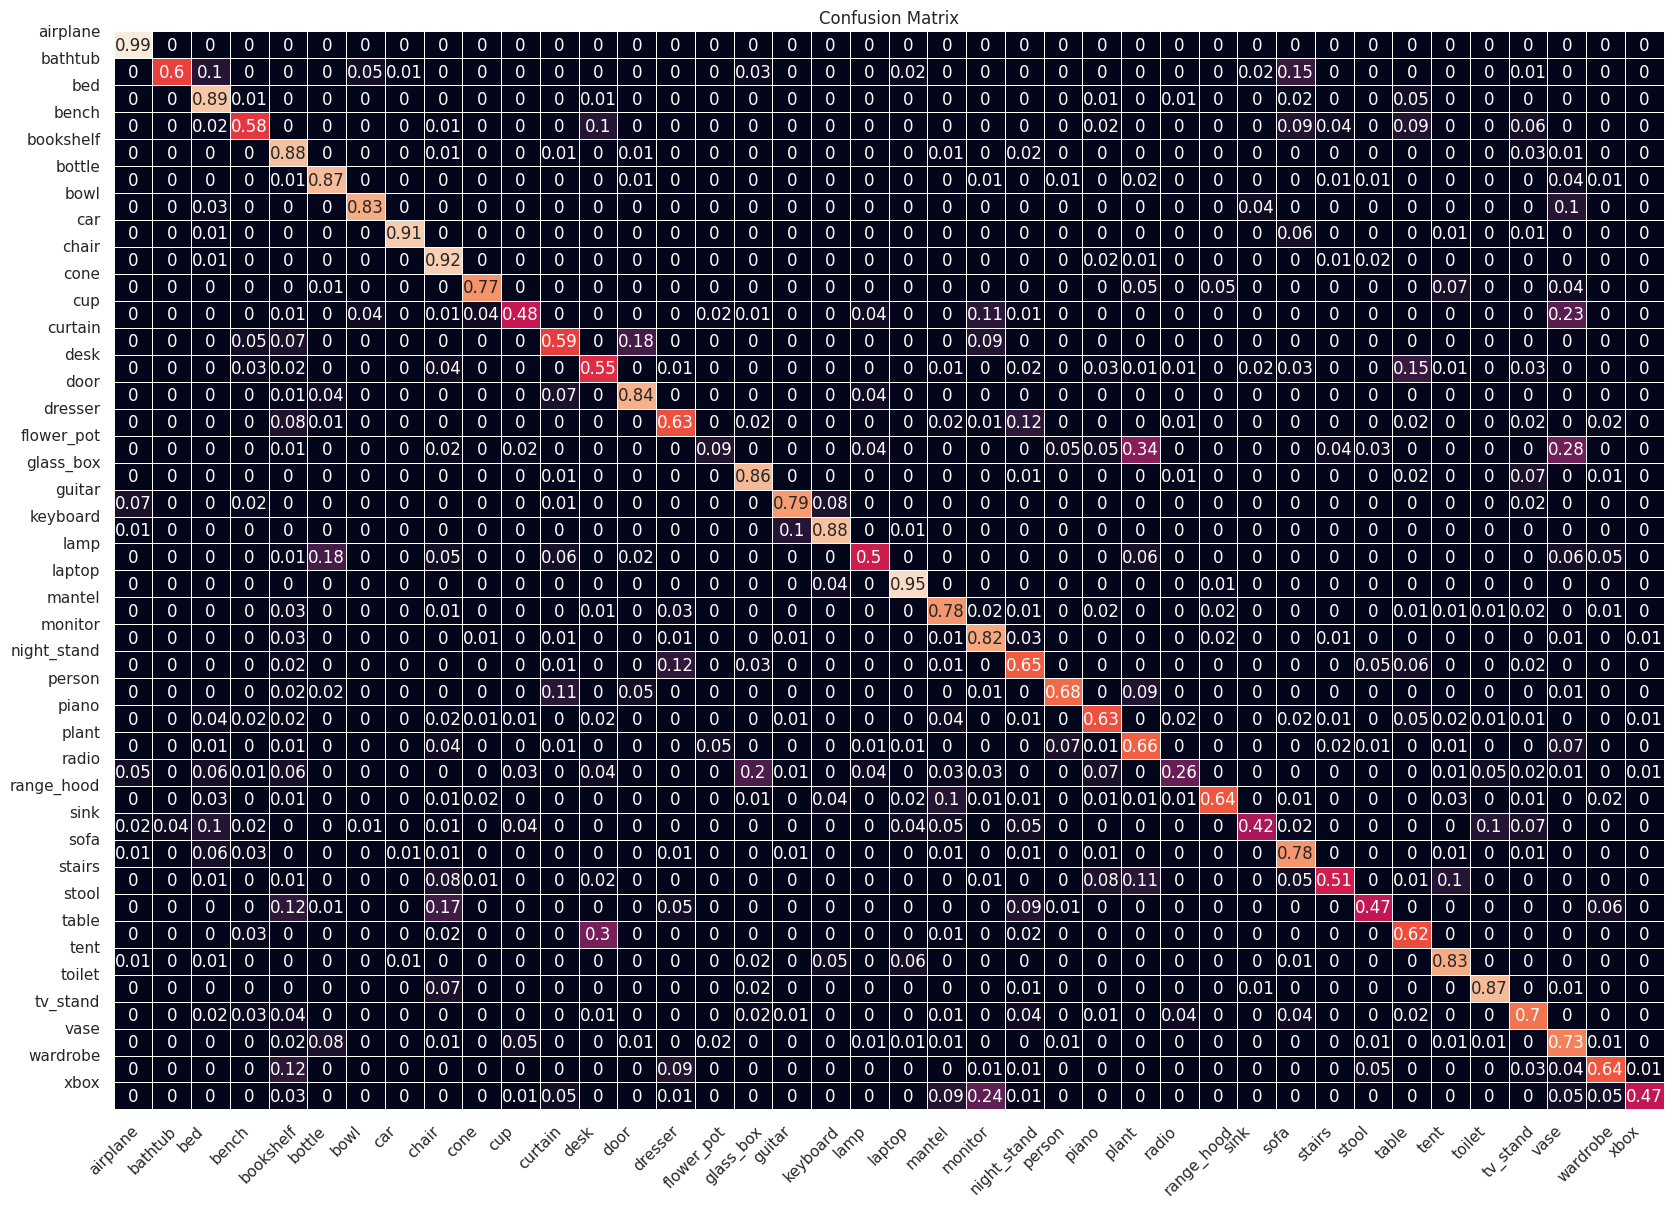

In [ ]:
trainer8.generateConfusionMatrix()